In [11]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
import copy

import matplotlib.pyplot as plt
import neuromodels as nm
import numpy as np
import pandas as pd
import pylfi
import quantities as pq
import scipy.stats as stats
import seaborn as sns

from elephant.conversion import BinnedSpikeTrain
from elephant.spike_train_correlation import correlation_coefficient
from elephant import statistics
from tqdm import tqdm_notebook as tqdm
from utils import *
from viziphant.rasterplot import rasterplot, rasterplot_rates
from viziphant.spike_train_correlation import plot_corrcoef

In [2]:
# Set plot style
sns.set(context="paper", style='darkgrid', rc={"axes.facecolor": "0.96"})

# Set fontsizes in figures
size = 10
tex_fonts = {
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern"],
    "axes.labelsize": size,
    "font.size": size,
    "legend.fontsize": size,
    "xtick.labelsize": size-1,
    "ytick.labelsize": size-1,
    'legend.handlelength': 2
}

plt.rcParams.update(tex_fonts)
plt.rc('text', usetex=True)

# Set path to save the figures
FIGURE_PATH = "./../latex/figures" 
TABLE_PATH = "./../latex/tables" 

def fig_path(fig_id):
    """
    Input name of figure to load or save with extension as dtype str
    """
    return os.path.join(FIGURE_PATH + "/", fig_id)


def tab_path(tab_id):
    """
    Input name of table to load or save with extension as dtype str
    """
    return os.path.join(TABLE_PATH + "/", tab_id)


def df_to_latex(df, outfile):
    """
    Render dataframe to a LaTeX tabular environment table and write to file
    """
    n = len(df.columns)
    col_format = n * 'c'
    # Render dataframe to a LaTeX tabular environment table and write to file
    pd.options.display.float_format = '{:,.3f}'.format
    df = df.apply(lambda x: x.astype(
        int) if np.allclose(x, x.astype(int)) else x)
    pd.options.display.latex.escape = False
    latex = df.to_latex(index=False, column_format=col_format)
    latex = latex.replace('\\toprule', '\\hline \\hline')
    latex = latex.replace('\\midrule', '\\hline \\hline')
    latex = latex.replace('\\bottomrule', '\\hline \\hline')

    with open(tab_path(outfile), 'w') as f:
        f.write(latex)

# Set figure size
pt = 410 #360

def set_size(width, fraction=1):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float
            Document textwidth or columnwidth in pts
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio

    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim

fs = set_size(pt, fraction=1)
print(fs)

(5.673170056731701, 3.5062119190183605)


In [3]:
path = "data/"

## Functions

In [9]:
def compute_rmspe(theta_true, theta_pred):
    """Root mean square percentage error (RMSPE)"""
    rmspe = np.sqrt(np.mean(np.square((theta_true - theta_pred) / theta_true)))
    return rmspe * 100

def compute_point_est(theta, density, point_estimate):
    """Compute point estimate"""
    if point_estimate == "mean":
        p_est = theta.mean()
        handle = "mean"
    elif point_estimate == "median":
        p_est = np.median(theta)
        handle = "median"
    elif point_estimate == "map":
        idx = np.argmax(density)
        p_est = theta[idx]
        handle = "MAP"
    return p_est, handle

def compute_hdi(theta, hdi_prob):
    """Highest (posterior) density interval"""
    theta = theta.flatten()
    n = len(theta)
    theta = np.sort(theta)
    interval_idx_inc = int(np.floor(hdi_prob * n))
    n_intervals = n - interval_idx_inc
    interval_width = np.subtract(theta[interval_idx_inc:],
                                 theta[:n_intervals],
                                 dtype=np.float_
                                 )
    min_idx = np.argmin(interval_width)
    hdi_min = theta[min_idx]
    hdi_max = theta[min_idx + interval_idx_inc]
    return (hdi_min, hdi_max)


def plot_posterior(df, theta_name, theta_true, point_estimate='map', hdi_prob=0.95, ax=None):
    
    if ax is None:
        ax = plt.gca()
        
    xdata = df[theta_name].to_numpy() 
    theta_true_ary = np.ones(len(xdata.flatten())) * theta_true
    rmspe = compute_rmspe(theta_true_ary, xdata)
    
    sns.kdeplot(data=df,
                x=theta_name,
                color='C0',
                label=f"Posterior RMSPE: {rmspe:.2f}\%",
                ax=ax
            )

    ax.axvline(theta_true,
               ymax=0.3,
               color='C3',
               label=fr"$\theta_\mathrm{{true}}: {theta_true}$"
              )
    kdeline = ax.lines[0]
    xs = kdeline.get_xdata()
    ys = kdeline.get_ydata()

    p_est, p_est_handle = compute_point_est(xs, ys, point_estimate)

    hdi_min, hdi_max = compute_hdi(xdata, hdi_prob=hdi_prob)

    ax.vlines(
        p_est,
        0,
        np.interp(p_est, xs, ys),
        color='b',
        ls=':',
        label=fr"$\hat{{\theta}}_\mathrm{{{p_est_handle}}}: {p_est:.3f}$"
    )

    ax.fill_between(
        xs,
        0,
        ys,
        facecolor='lightblue',
        alpha=0.3
    )

    ax.fill_between(
        xs,
        0,
        ys,
        where=(hdi_min <= xs) & (xs <= hdi_max),
        interpolate=True,
        facecolor='steelblue',
        alpha=0.3,
        label=f"{hdi_prob*100}\% HDI: [{hdi_min:.3f}, {hdi_max:.3f}]"
    )

    handles, labels = ax.get_legend_handles_labels()

    ax.set(yticks=[])

    ax.legend(
        handles,
        labels,
        loc='center left',
        bbox_to_anchor=(1.04, 0.5),
        fancybox=True,
        borderaxespad=0.1,
        ncol=1,
        frameon=False
    )
    
    
def plot_joint(df, theta1_name, theta2_name, theta1_true=None, theta2_true=None, levels=6, alpha=0.3, height=4, **kwargs):

    g = sns.jointplot(
        data=df,
        x=theta1_name,
        y=theta2_name,
        kind="kde",
        fill=True,
        height=height,
        **kwargs
    )

    g.plot_joint(
        sns.kdeplot,
        color="k",
        levels=levels,
        alpha=alpha
    )

    if theta1_true is not None and theta2_true is not None:
        g.ax_joint.plot([theta1_true], [theta2_true], 'ro')
        g.ax_joint.axvline(theta1_true, color='r', ls=":")
        g.ax_joint.axhline(theta2_true, color='r', ls=":")
        g.ax_marg_x.axvline(theta1_true, color='r')
        g.ax_marg_y.axhline(theta2_true, color='r')

    return g


def slice_spiketrains(spiketrains, t_start=None, t_stop=None):

    spiketrains_slice = []
    for spiketrain in spiketrains:
        if t_start is None:
            t_start = spiketrain.t_start
        if t_stop is None:
            t_stop = spiketrain.t_stop

        spiketrain_slice = spiketrain[np.where(
            (spiketrain > t_start) & (spiketrain < t_stop))]
        spiketrain_slice.t_start = t_start
        spiketrain_slice.t_stop = t_stop
        spiketrains_slice.append(spiketrain_slice)
    return spiketrains_slice

## Simulator

In [5]:
# Fixed model parameters
order = 2500    # -> NE=10,000 ; NI=2500 ; N_tot=12,500 ; CE=1000 ; CI=250
epsilon = 0.1   # connection probability
D = 1.5         # synaptic delay (ms)
T = 1000        # simulation time (ms)
N_rec = 20      # record output from N_rec neurons
n_type = 'exc'  # record excitatory spike trains
J = 0.1         # excitatory synapse weight (mV)

# NEST settings
threads = 8        # number of threads to use in simulation
print_time = False  # print simulated time or not

# simulator model
bnet = nm.models.BrunelNet(order=order,
                           epsilon=epsilon,
                           D=D,
                           J=J,
                           T=T,
                           N_rec=N_rec,
                           n_type=n_type,
                           print_time=print_time,
                           threads=threads
                           )

# statistics calculator
s_stats = ["mean_firing_rate",  # rate estimation
           "mean_cv",           # spike interval statistic
           "fanofactor"         # statistic across spike trains
           ]

t_start = 100. * pq.ms  # record after 100 ms to avoid transient effects
t_stop = T * pq.ms

sts = nm.statistics.SpikeTrainStats(stats=s_stats,
                                    t_start=t_start,
                                    t_stop=t_stop
                                    )

## Load posterior

In [6]:
posterior = load_posterior('data/brunel_posterior.pkl')

## AI state

### Observation

In [48]:
def load_spiketrain(filename):
    with open(filename, 'rb') as fp:
        spiketrain = pickle.load(fp)
    return spiketrain

In [49]:
g_ai = 5.   
eta_ai = 2. 

spiketrains_ai = load_spiketrain('data/obs_ai_data.pkl')
s_obs_ai = sts(spiketrains_ai)

df_obs_ai = pd.DataFrame(np.array([s_obs_ai]),
                      columns=['Mean firing rate', 'Mean CV', 'Fano factor'])

df_obs_ai.insert(0, r"$\eta$", [2.])
df_obs_ai.insert(1, r"$g$", [5.])
df_obs_ai

,$\eta$,$g$,Mean firing rate,Mean CV,Fano factor
0,2.0,5.0,0.036611,0.42506,0.234138


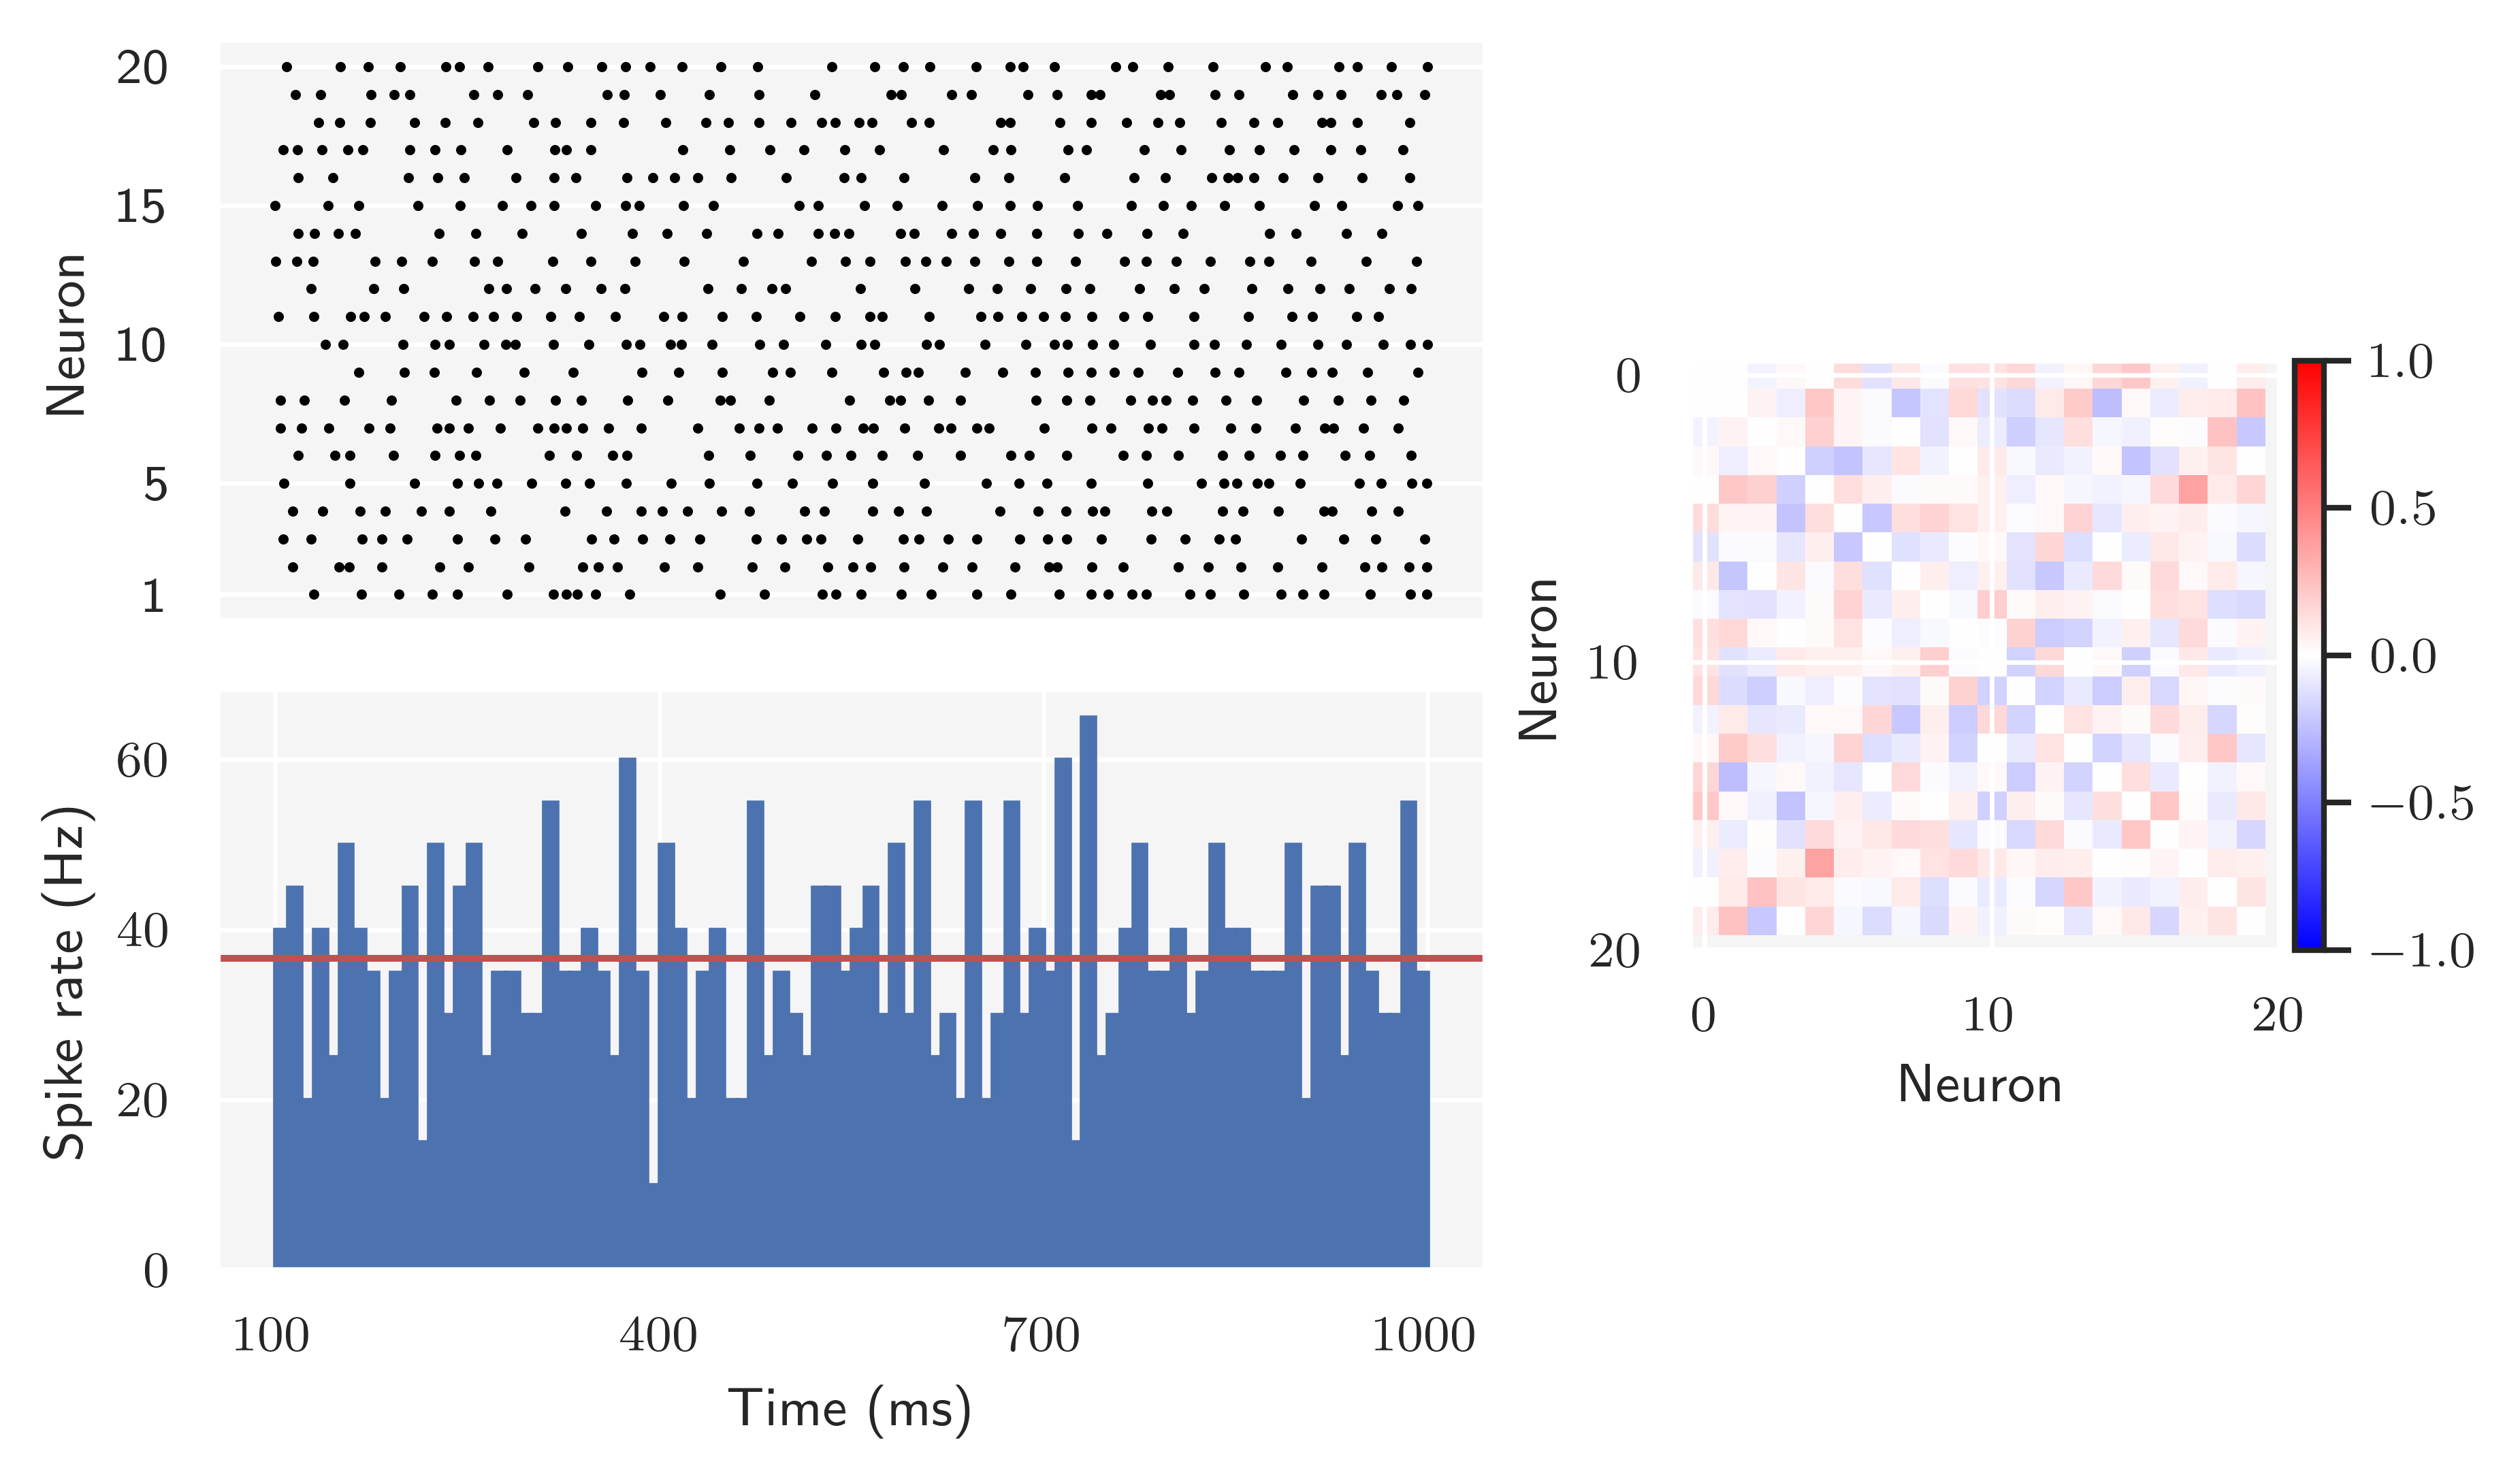

In [59]:
sns.set(context="paper", style='darkgrid', rc={"axes.facecolor": "0.96"})
fig = plt.figure(figsize=fs, constrained_layout=True, dpi=300)
gs = fig.add_gridspec(2, 2, width_ratios=[4, 2])

# computations
t_start = 100. * pq.ms
t_stop = T * pq.ms
spiketrains_slice = slice_spiketrains(spiketrains_ai, t_start=t_start, t_stop=t_stop)
hist = statistics.time_histogram(spiketrains_slice, bin_size=10 * pq.ms, output='rate')
mean_frate = sts.mean_firing_rate(spiketrains_slice, units=1 / pq.ms)
binned_spiketrains = BinnedSpikeTrain(spiketrains_slice, bin_size=10 * pq.ms)
corrcoef_matrix = correlation_coefficient(binned_spiketrains)


# rasterplot
ax1 = fig.add_subplot(gs[0, :-1])
rasterplot(spiketrains_slice, s=1, c='black', axes=ax1)
ax1.set(yticks=[0, 4, 9, 14, 19], yticklabels=[1, 5, 10, 15, 20], xticks=[], ylabel='Neuron', xlabel='')

# rate plot 
ax2 = fig.add_subplot(gs[1, :-1])
ax2.bar(hist.times,
          hist.magnitude.flatten() * 1000,
          width=hist.sampling_period, 
          color='C0',
          edgecolor='C0',
          align='edge',
          alpha=1
         )
ax2.axhline(mean_frate * 1000, color='C3', ls='-')   
ax2.set(xticks=[100, 400, 700, 1000], ylabel='Spike rate (Hz)', xlabel='Time (ms)') 

# correlation
ax3 = fig.add_subplot(gs[0:, -1])
with sns.axes_style("white"):

    plot_corrcoef(corrcoef_matrix, colormap='bwr', correlation_range='full', axes=ax3)
    ax3.set(xticks=[0, 10, 20], yticks=[0, 10, 20], xlabel='Neuron', ylabel='Neuron')
    
fig.savefig(fig_path('brunel_ai_observation.pdf'), 
            format='pdf', 
            dpi=300,
            bbox_inches='tight'
           )

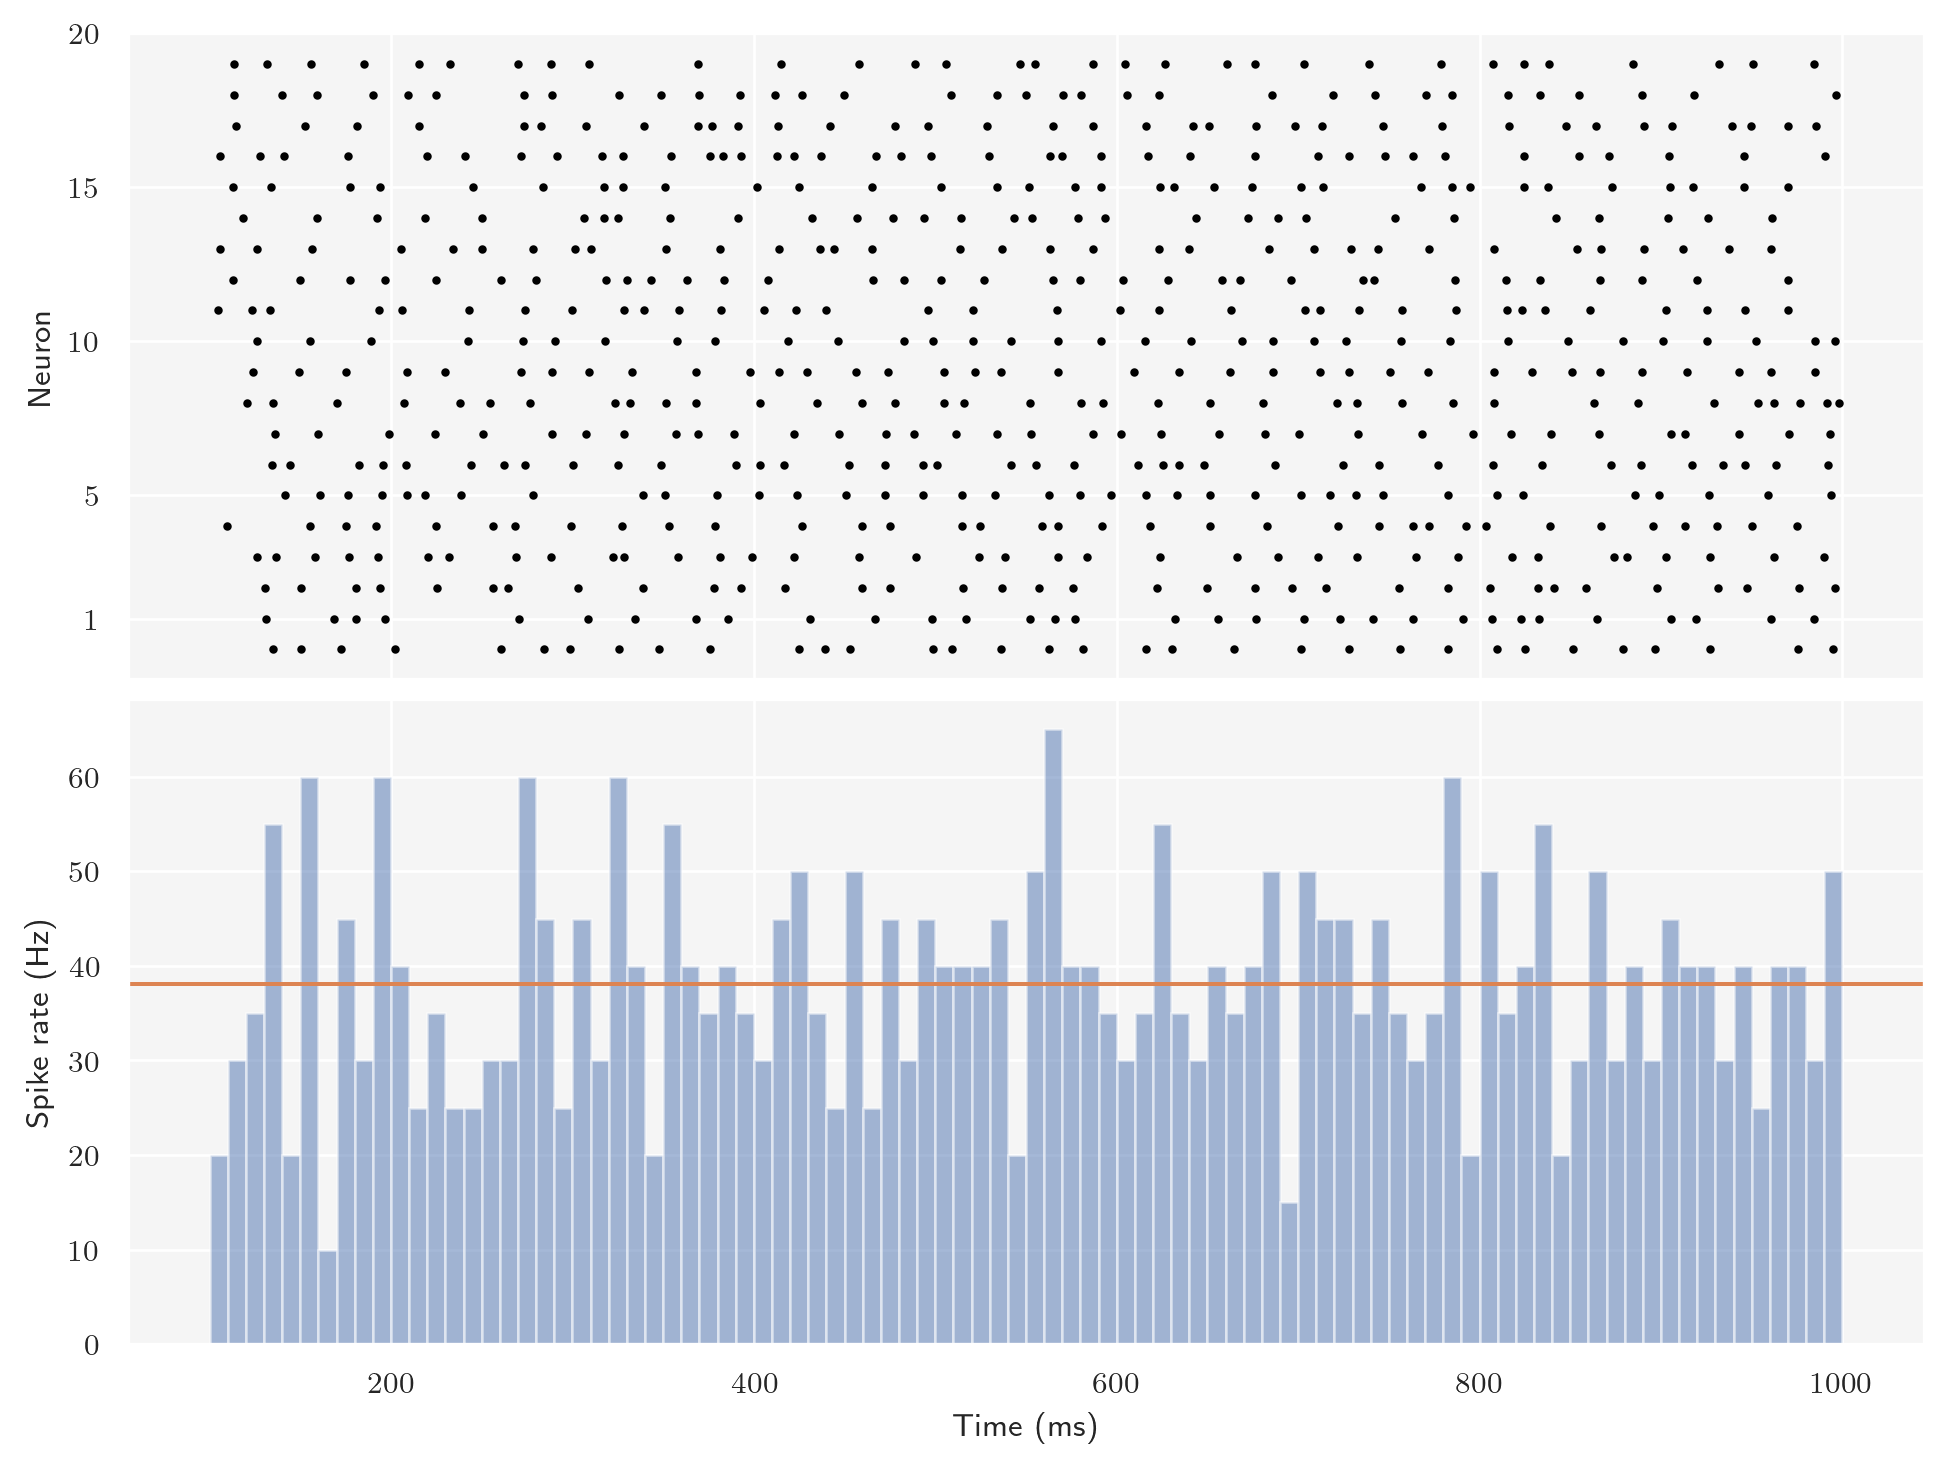

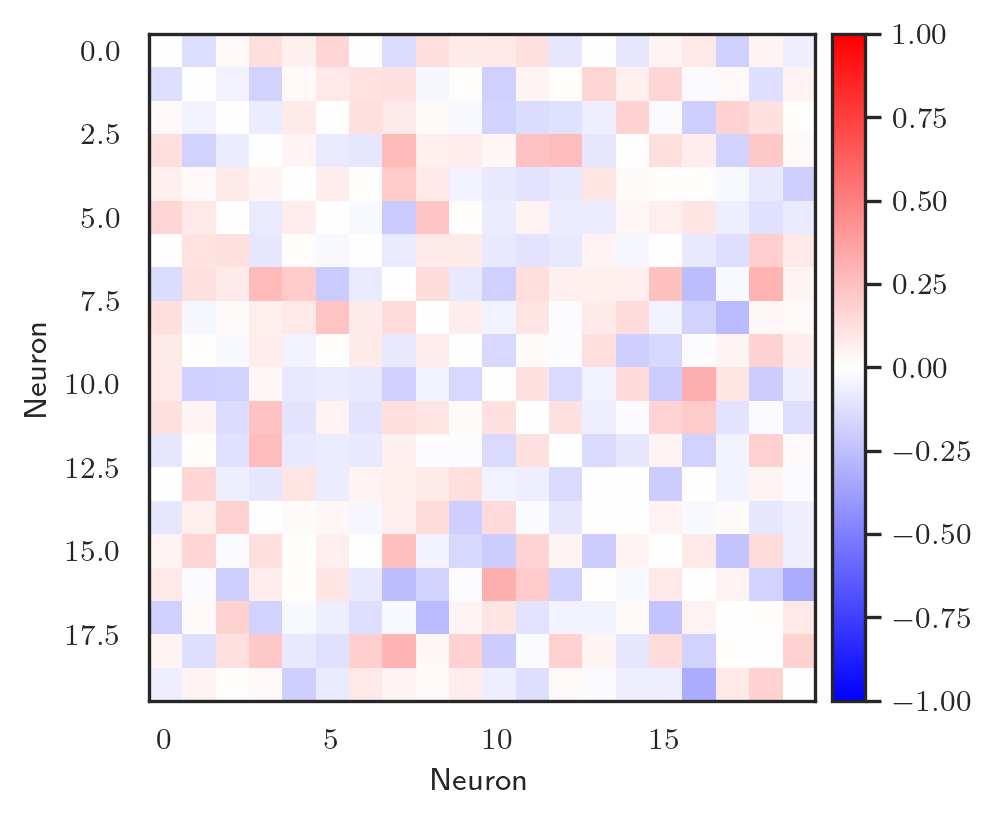

In [12]:
# NOT USED

sns.set(context="paper", style='darkgrid', rc={"axes.facecolor": "0.96"})



t_start = 100. * pq.ms
t_stop = T * pq.ms

spiketrains_ai_slice = slice_spiketrains(spiketrains_ai,
                                         t_start=t_start,
                                         t_stop=t_stop
                                         )

hist_ai = statistics.time_histogram(spiketrains_ai_slice, bin_size=10 * pq.ms, output='rate')

mean_frate_ai = sts.mean_firing_rate(spiketrains_ai_slice, units=1 / pq.ms)

# Raster plot
fig, axes = plt.subplots(nrows=2, 
                         ncols=1,
                         figsize=(8, 6),
                         constrained_layout=True,
                         dpi=120,
                         sharex=True
                       )

rasterplot(spiketrains_ai_slice, s=3, c='black', axes=axes[0])

axes[0].set(yticks=[1, 5, 10, 15, 20],
            ylabel='Neuron',
            xlabel=''
           ) 

# Rate plot
axes[1].bar(hist_ai.times, 
            hist_ai.magnitude.flatten() * 1000, 
            width=hist_ai.sampling_period, 
            align='edge', 
            alpha=0.5)

axes[1].axhline(mean_frate_ai * 1000, color='C1')        

axes[1].set(ylabel='Spike rate (Hz)',
            xlabel='Time (ms)'
           ) 

# Correlation coefficient matrix
binned_spiketrains_ai = BinnedSpikeTrain(spiketrains_ai_slice, bin_size=10 * pq.ms)
corrcoef_matrix_ai = correlation_coefficient(binned_spiketrains_ai)

with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize=fs, tight_layout=True, dpi=120)

    plot_corrcoef(corrcoef_matrix_ai, colormap='bwr', correlation_range='full', axes=ax)

    ax.set(xlabel='Neuron',
           ylabel='Neuron',
           )
    
plt.show()

### Infer Posterior

In [13]:
thetas_ai = posterior.sample((1000,), x=s_obs_ai)

param_names =  [r'$\eta$', r'$g$']
data_ai = dict(zip(param_names, np.stack(thetas_ai, axis=-1)))
df_ai = pd.DataFrame.from_dict(data_ai)
df_ai

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

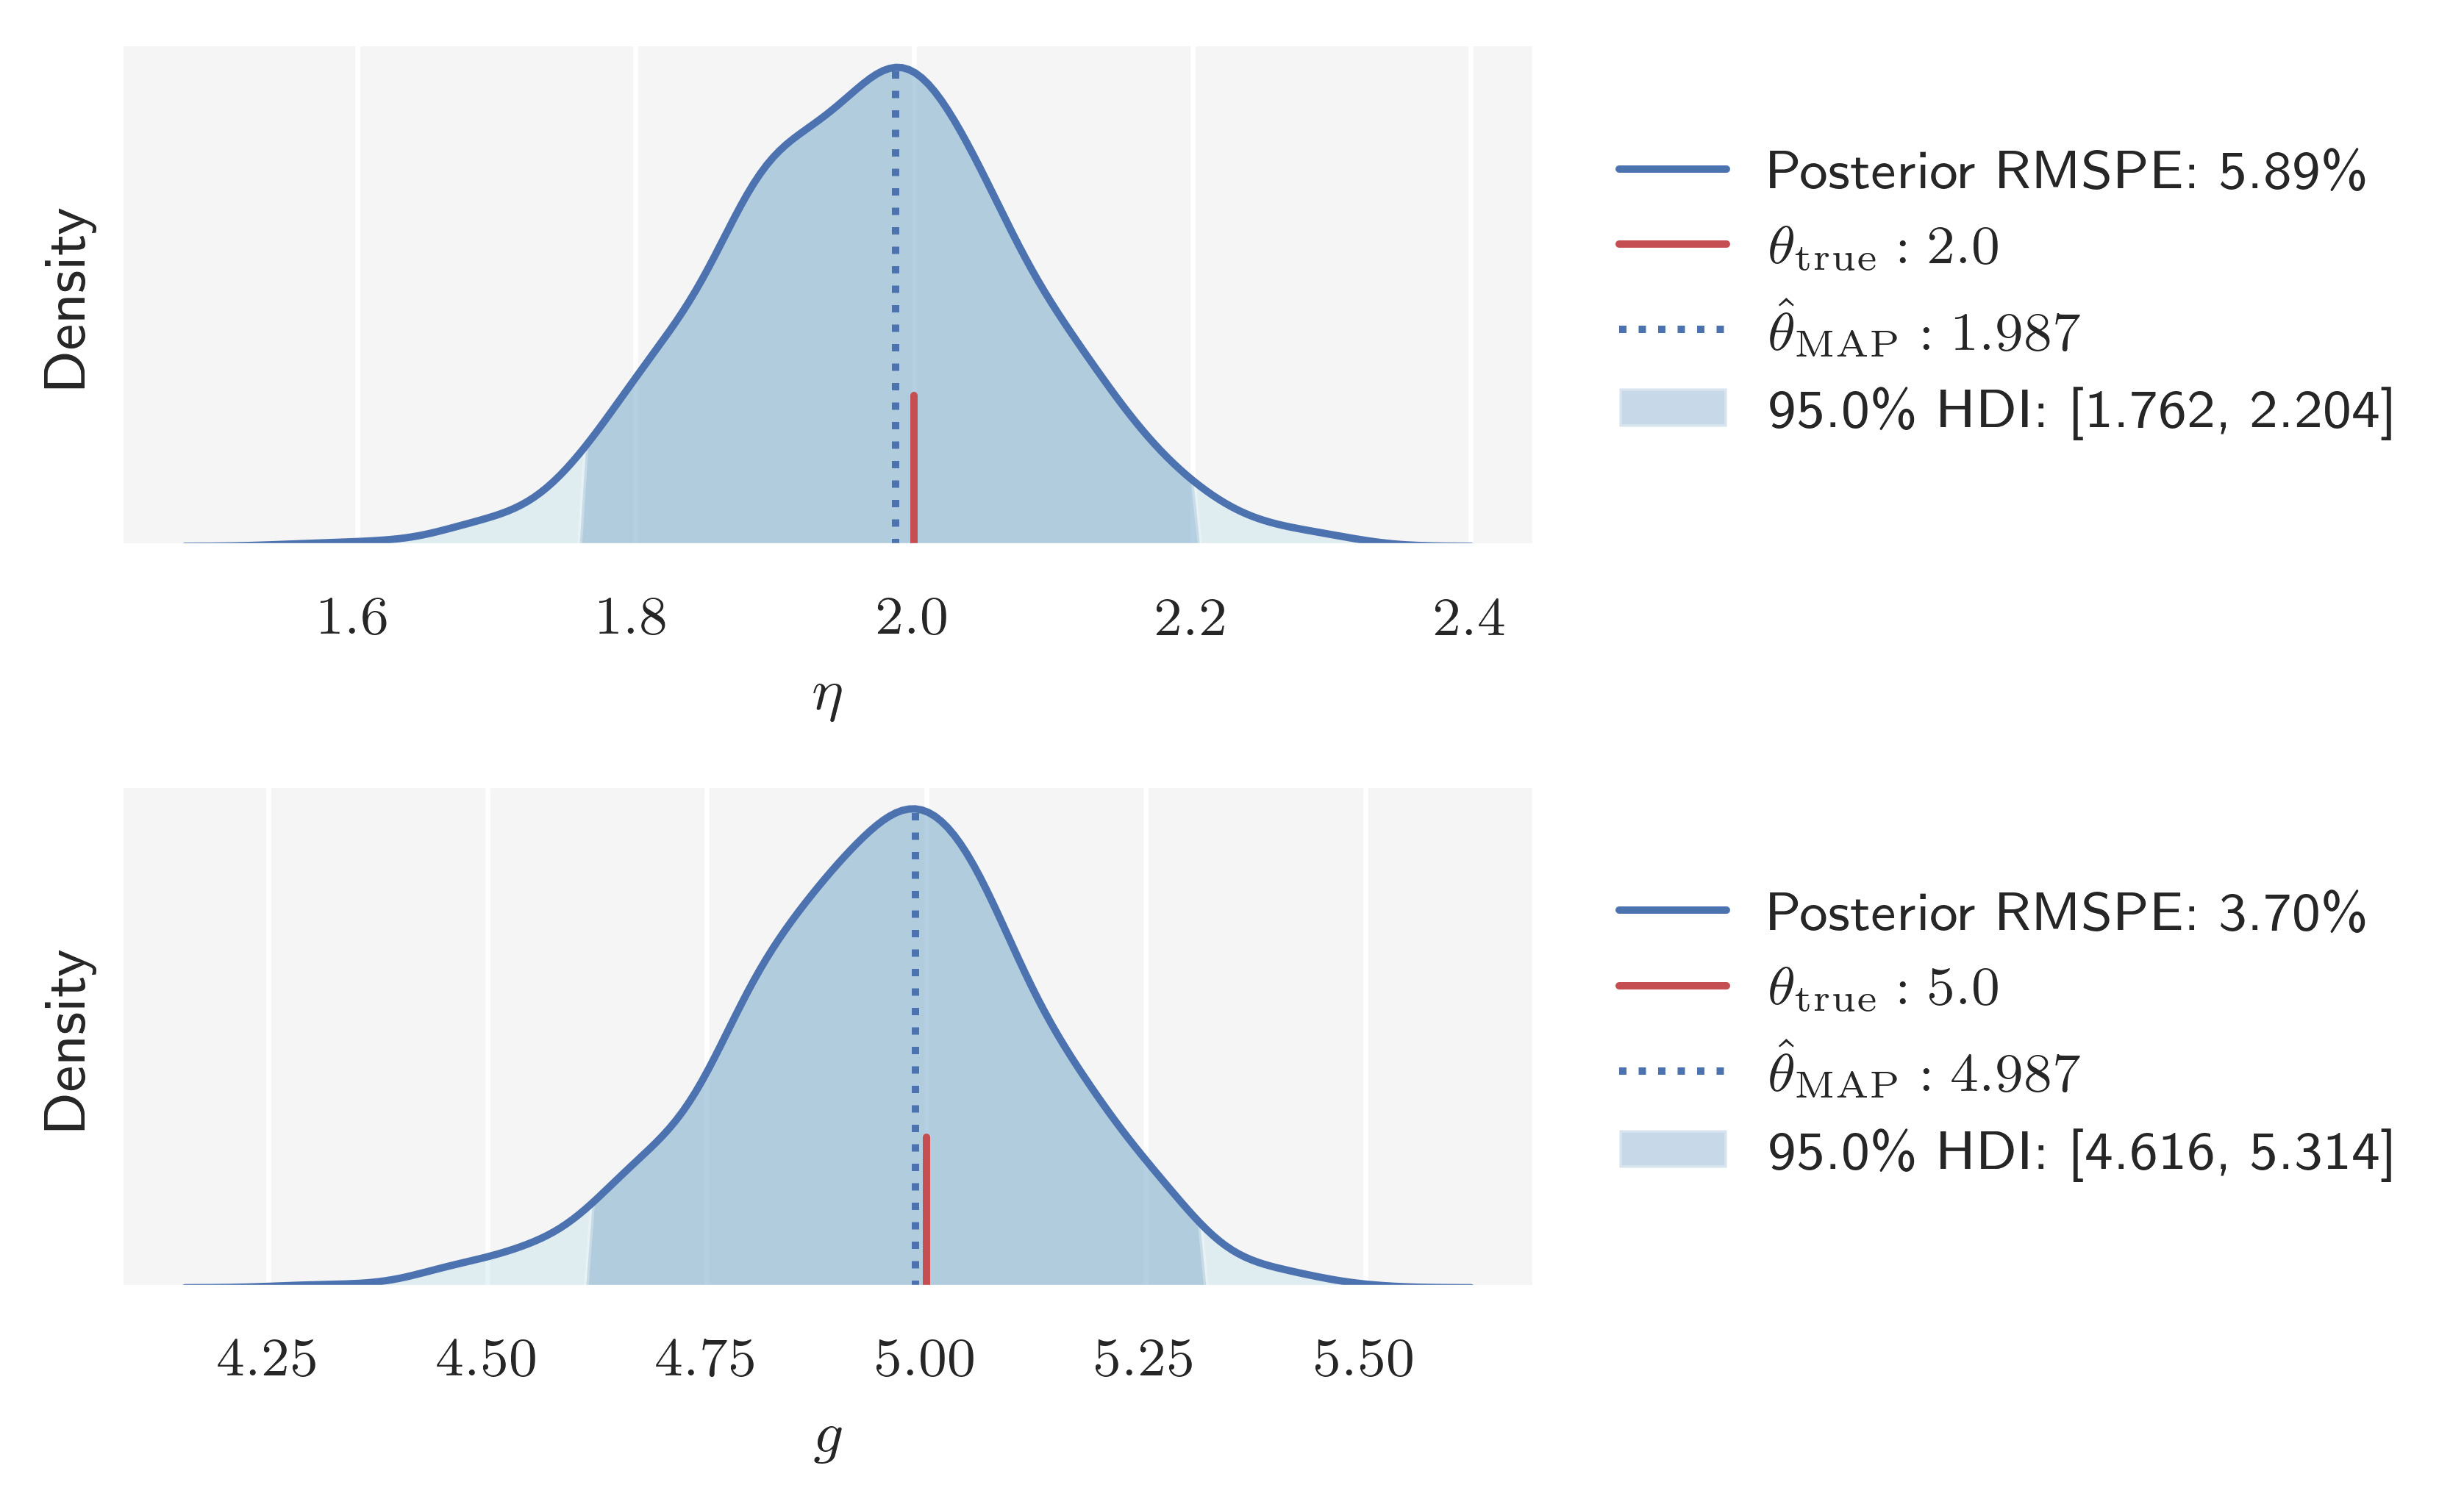

In [38]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=fs, tight_layout=True, dpi=300)
plot_posterior(df_ai, r'$\eta$', point_estimate='map', theta_true=eta_ai, ax=axes[0])
plot_posterior(df_ai, r'$g$', point_estimate='map', theta_true=g_ai, ax=axes[1])

fig.savefig(fig_path('brunel_post_ai_sbi.pdf'), 
            format='pdf', 
            dpi=300,
            bbox_inches='tight'
           )

### Posterior predictive check

In [18]:
size = 50
idxs = np.random.randint(0, len(df_ai.index), size)
thetas_pred_ai = df_ai.iloc[idxs].to_numpy()

s_stats_pred_ai = []
corr_pred_ai = []

for thetas_ in thetas_pred_ai:
    spiketrains_pred_ai = bnet(*thetas_)
    s_stats_pred_i_ai = sts(spiketrains_pred_ai)
    s_stats_pred_ai.append(s_stats_pred_i_ai)
    
    spiketrains_pred_ai_slice = slice_spiketrains(spiketrains_pred_ai,
                                                  t_start=t_start,
                                                  t_stop=t_stop
                                                 )
    
    binned_spiketrains_pred_ai = BinnedSpikeTrain(spiketrains_pred_ai_slice, bin_size=10 * pq.ms)
    corrcoef_matrix_pred_ai = correlation_coefficient(binned_spiketrains_pred_ai)
    corr_pred_ai.append(corrcoef_matrix_pred_ai)
    
    
data_pred_ai = dict(zip(s_stats, np.stack(s_stats_pred_ai, axis=-1)))
df_pred_ai = pd.DataFrame.from_dict(data_pred_ai)
df_pred_ai.insert(0, r"$\eta$", thetas_pred_ai[:, 0])
df_pred_ai.insert(1, r"$g$", thetas_pred_ai[:, 1])

df_pred_ai.rename(columns={"mean_firing_rate": "Mean firing rate",
                           "mean_cv": "Mean CV",
                           "fanofactor": "Fano factor"
                          },
                  inplace=True
                 )

df_pred_ai

In [20]:
eta_ai_mean = np.mean(thetas_pred_ai[:, 0])
g_ai_mean = np.mean(thetas_pred_ai[:, 1])
s_stats_ai_mean = np.mean(np.array(s_stats_pred_ai), axis=0)
df_pred_ai_mean = pd.DataFrame(np.array([s_stats_ai_mean]),
                               columns=['Mean firing rate', 'Mean CV', 'Fano factor']
                              )

df_pred_ai_mean.insert(0, r"$\eta$", [eta_ai_mean])
df_pred_ai_mean.insert(1, r"$g$", [g_ai_mean])

df_pred_ai_mean

,$\eta$,$g$,Mean firing rate,Mean CV,Fano factor
0,1.96445,4.96655,0.038079,0.41638,0.155257


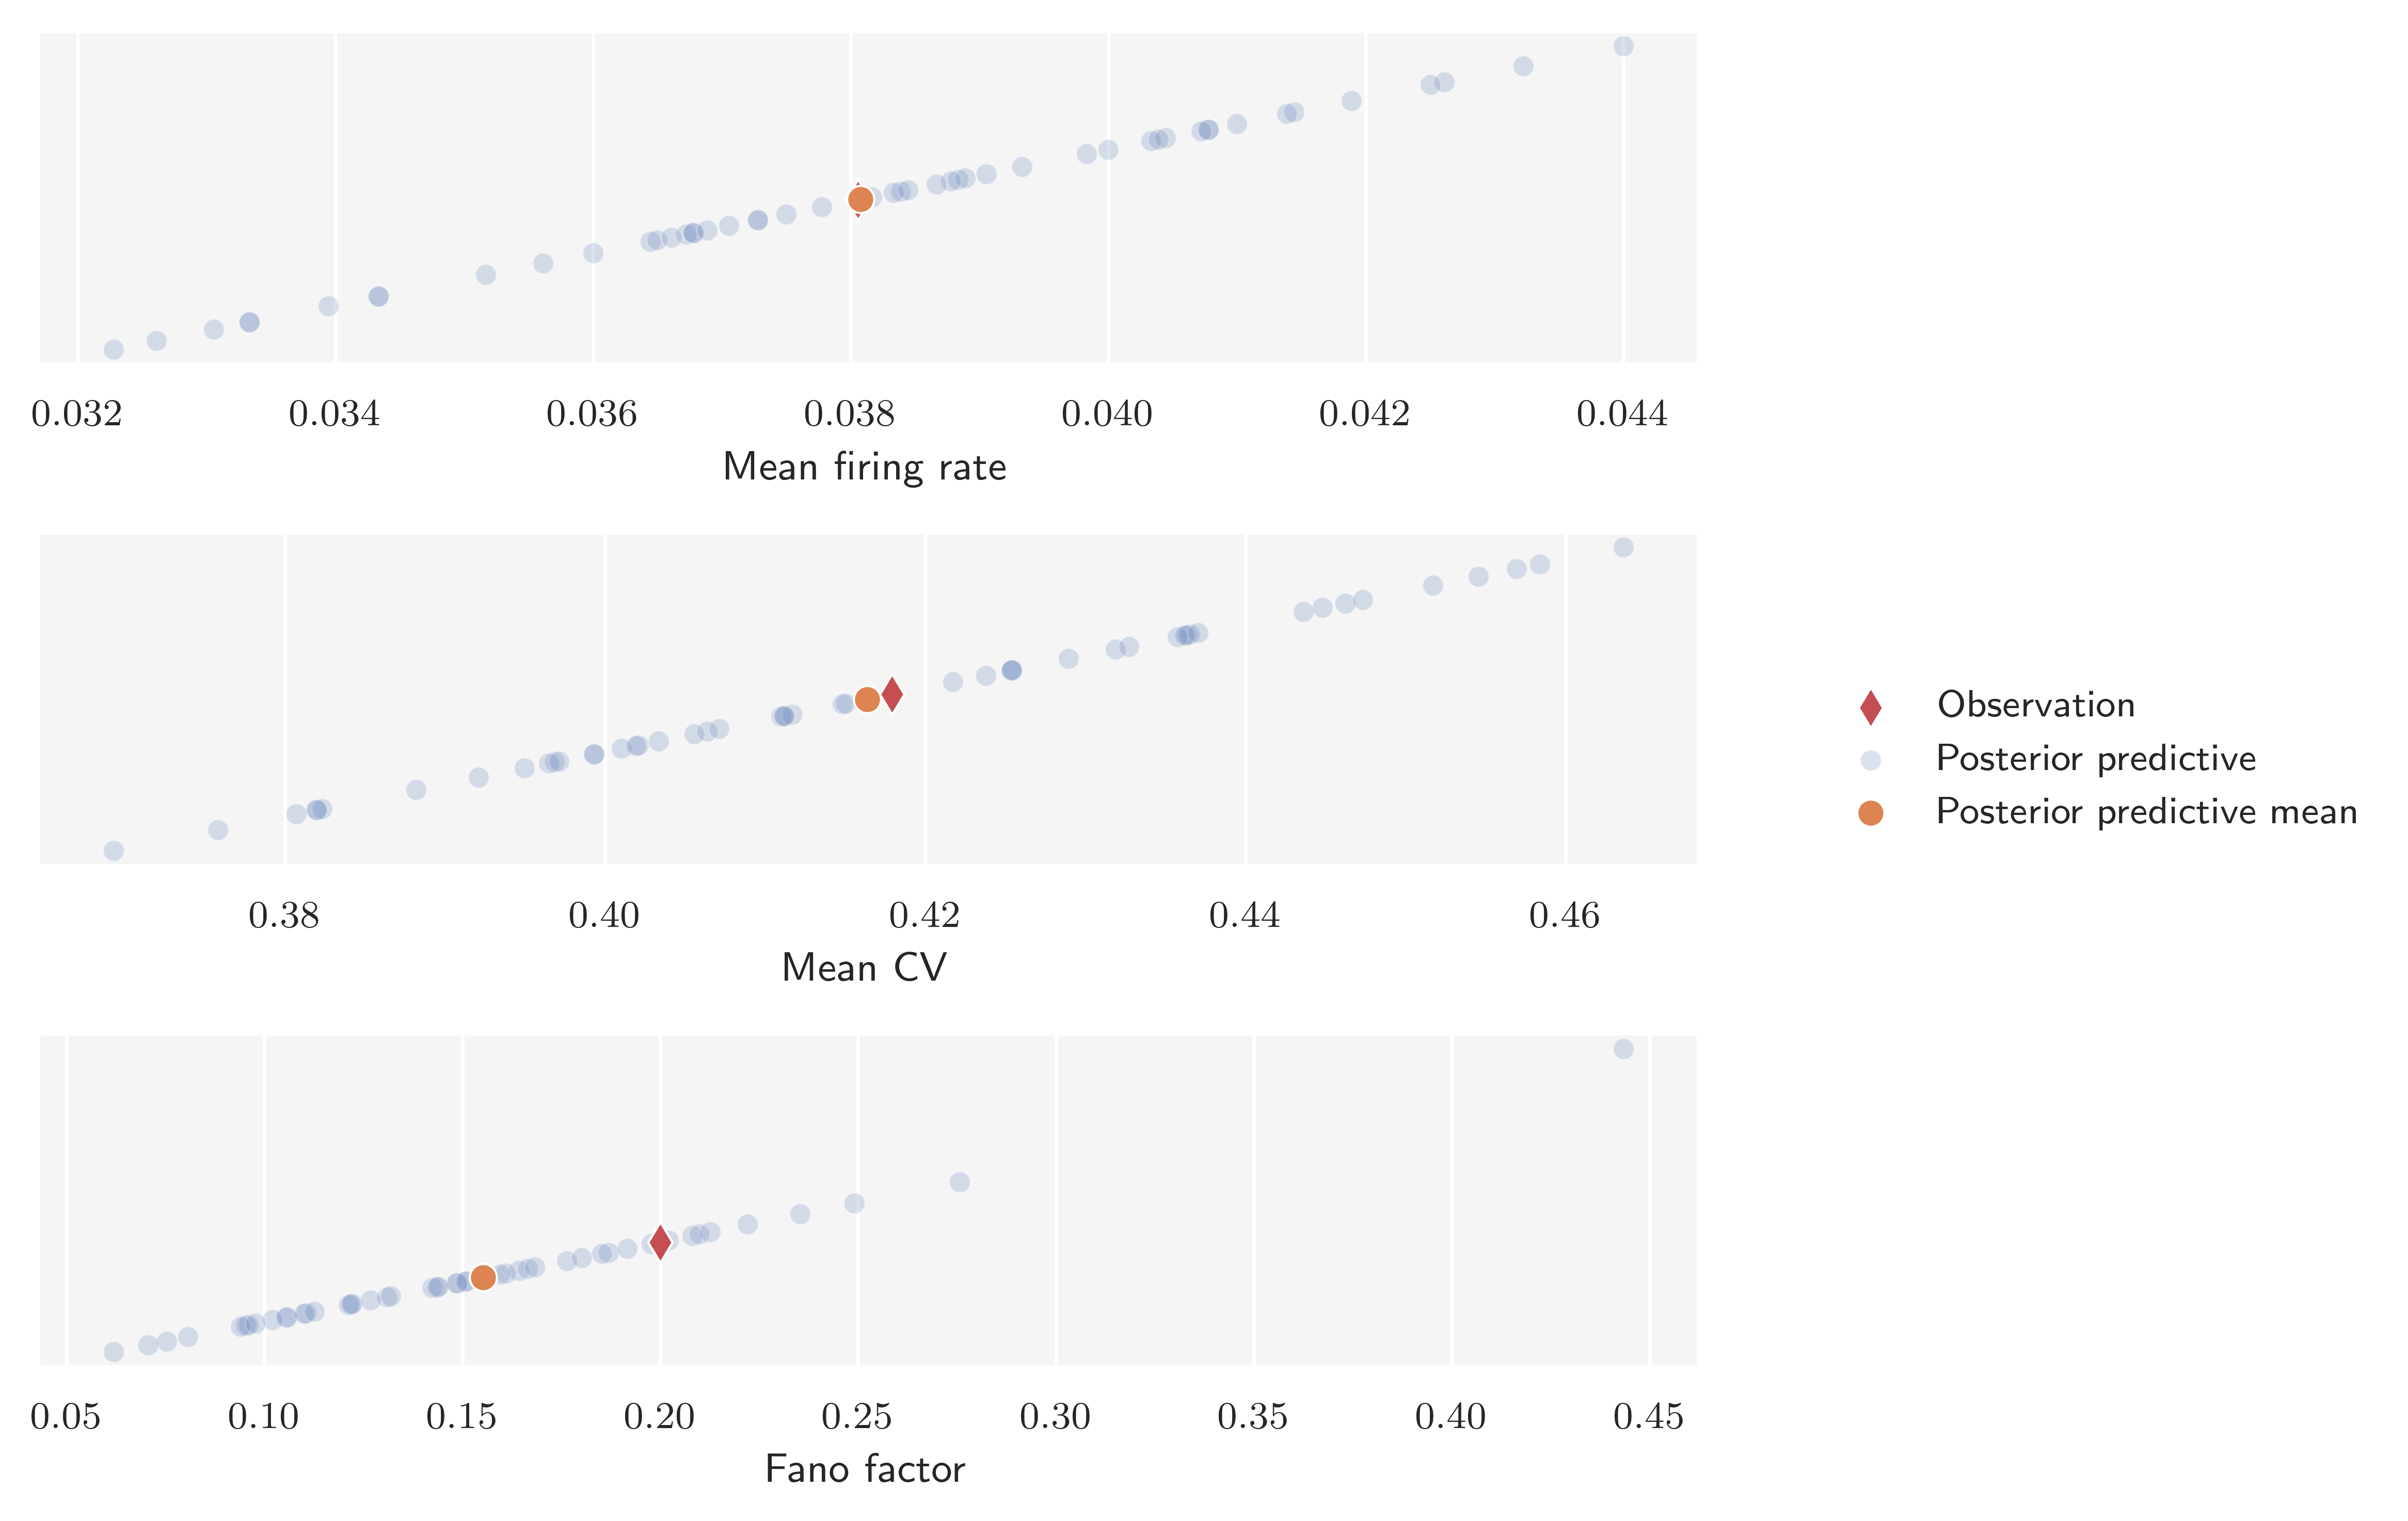

In [39]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(fs[0], 5), tight_layout=True, dpi=300)

# Mean firing rate
ax = axes[0]

sns.scatterplot(data=df_obs_ai, 
                x="Mean firing rate", 
                y="Mean firing rate", 
                color='r',
                marker='d',
                s=45,
                label='Observation',
                ax=ax,
                zorder=2
               )

sns.scatterplot(data=df_pred_ai, 
                x="Mean firing rate", 
                y="Mean firing rate", 
                color='C0',
                alpha=0.2,
                #s='d',
                label='Posterior predictive',
                ax=ax,
                zorder=1
               )

sns.scatterplot(data=df_pred_ai_mean, 
                x="Mean firing rate", 
                y="Mean firing rate", 
                color='C1',
                s=40,
                label='Posterior predictive mean',
                ax=ax,
                zorder=3
               )

ax.set(yticks=[],
       ylabel='')

# Mean CV
ax2 = axes[1]

sns.scatterplot(data=df_obs_ai, 
                x="Mean CV", 
                y="Mean CV", 
                color='r',
                marker='d',
                s=45,
                ax=ax2,
                zorder=2
               )

sns.scatterplot(data=df_pred_ai, 
                x="Mean CV", 
                y="Mean CV", 
                color='C0',
                alpha=0.2,
                ax=ax2,
                zorder=1
               )

sns.scatterplot(data=df_pred_ai_mean, 
                x="Mean CV", 
                y="Mean CV", 
                color='C1',
                s=40,
                ax=ax2,
                zorder=3
               )

ax2.set(yticks=[],
        ylabel='')

# Fano factor
ax3 = axes[2]

sns.scatterplot(data=df_obs_ai, 
                x="Fano factor", 
                y="Fano factor", 
                color='r',
                marker='d',
                s=45,
                ax=ax3,
                zorder=2
               )

sns.scatterplot(data=df_pred_ai, 
                x="Fano factor", 
                y="Fano factor", 
                color='C0',
                alpha=0.2,
                ax=ax3,
                zorder=1
               )

sns.scatterplot(data=df_pred_ai_mean, 
                x="Fano factor", 
                y="Fano factor", 
                color='C1',
                s=40,
                ax=ax3,
                zorder=3
               )

ax3.set(yticks=[],
        ylabel='')

# legend

handles, labels = ax.get_legend_handles_labels()

fig.legend(
    handles,
    labels,
    loc='center left',
    bbox_to_anchor=(1.04, 0.5),
    fancybox=True,
    borderaxespad=0.1,
    ncol=1,
    frameon=False
)

ax.legend([], [], frameon=False)


fig.savefig(fig_path('brunel_post_pred_ai_sbi.pdf'), 
            format='pdf',
            dpi=300,
            bbox_inches='tight'
           )

In [23]:
corr_pred_ai = np.array(corr_pred_ai)
corr_pred_ai_mean = np.mean(corr_pred_ai, axis=0)
corr_pred_ai_std = np.std(corr_pred_ai, axis=0)

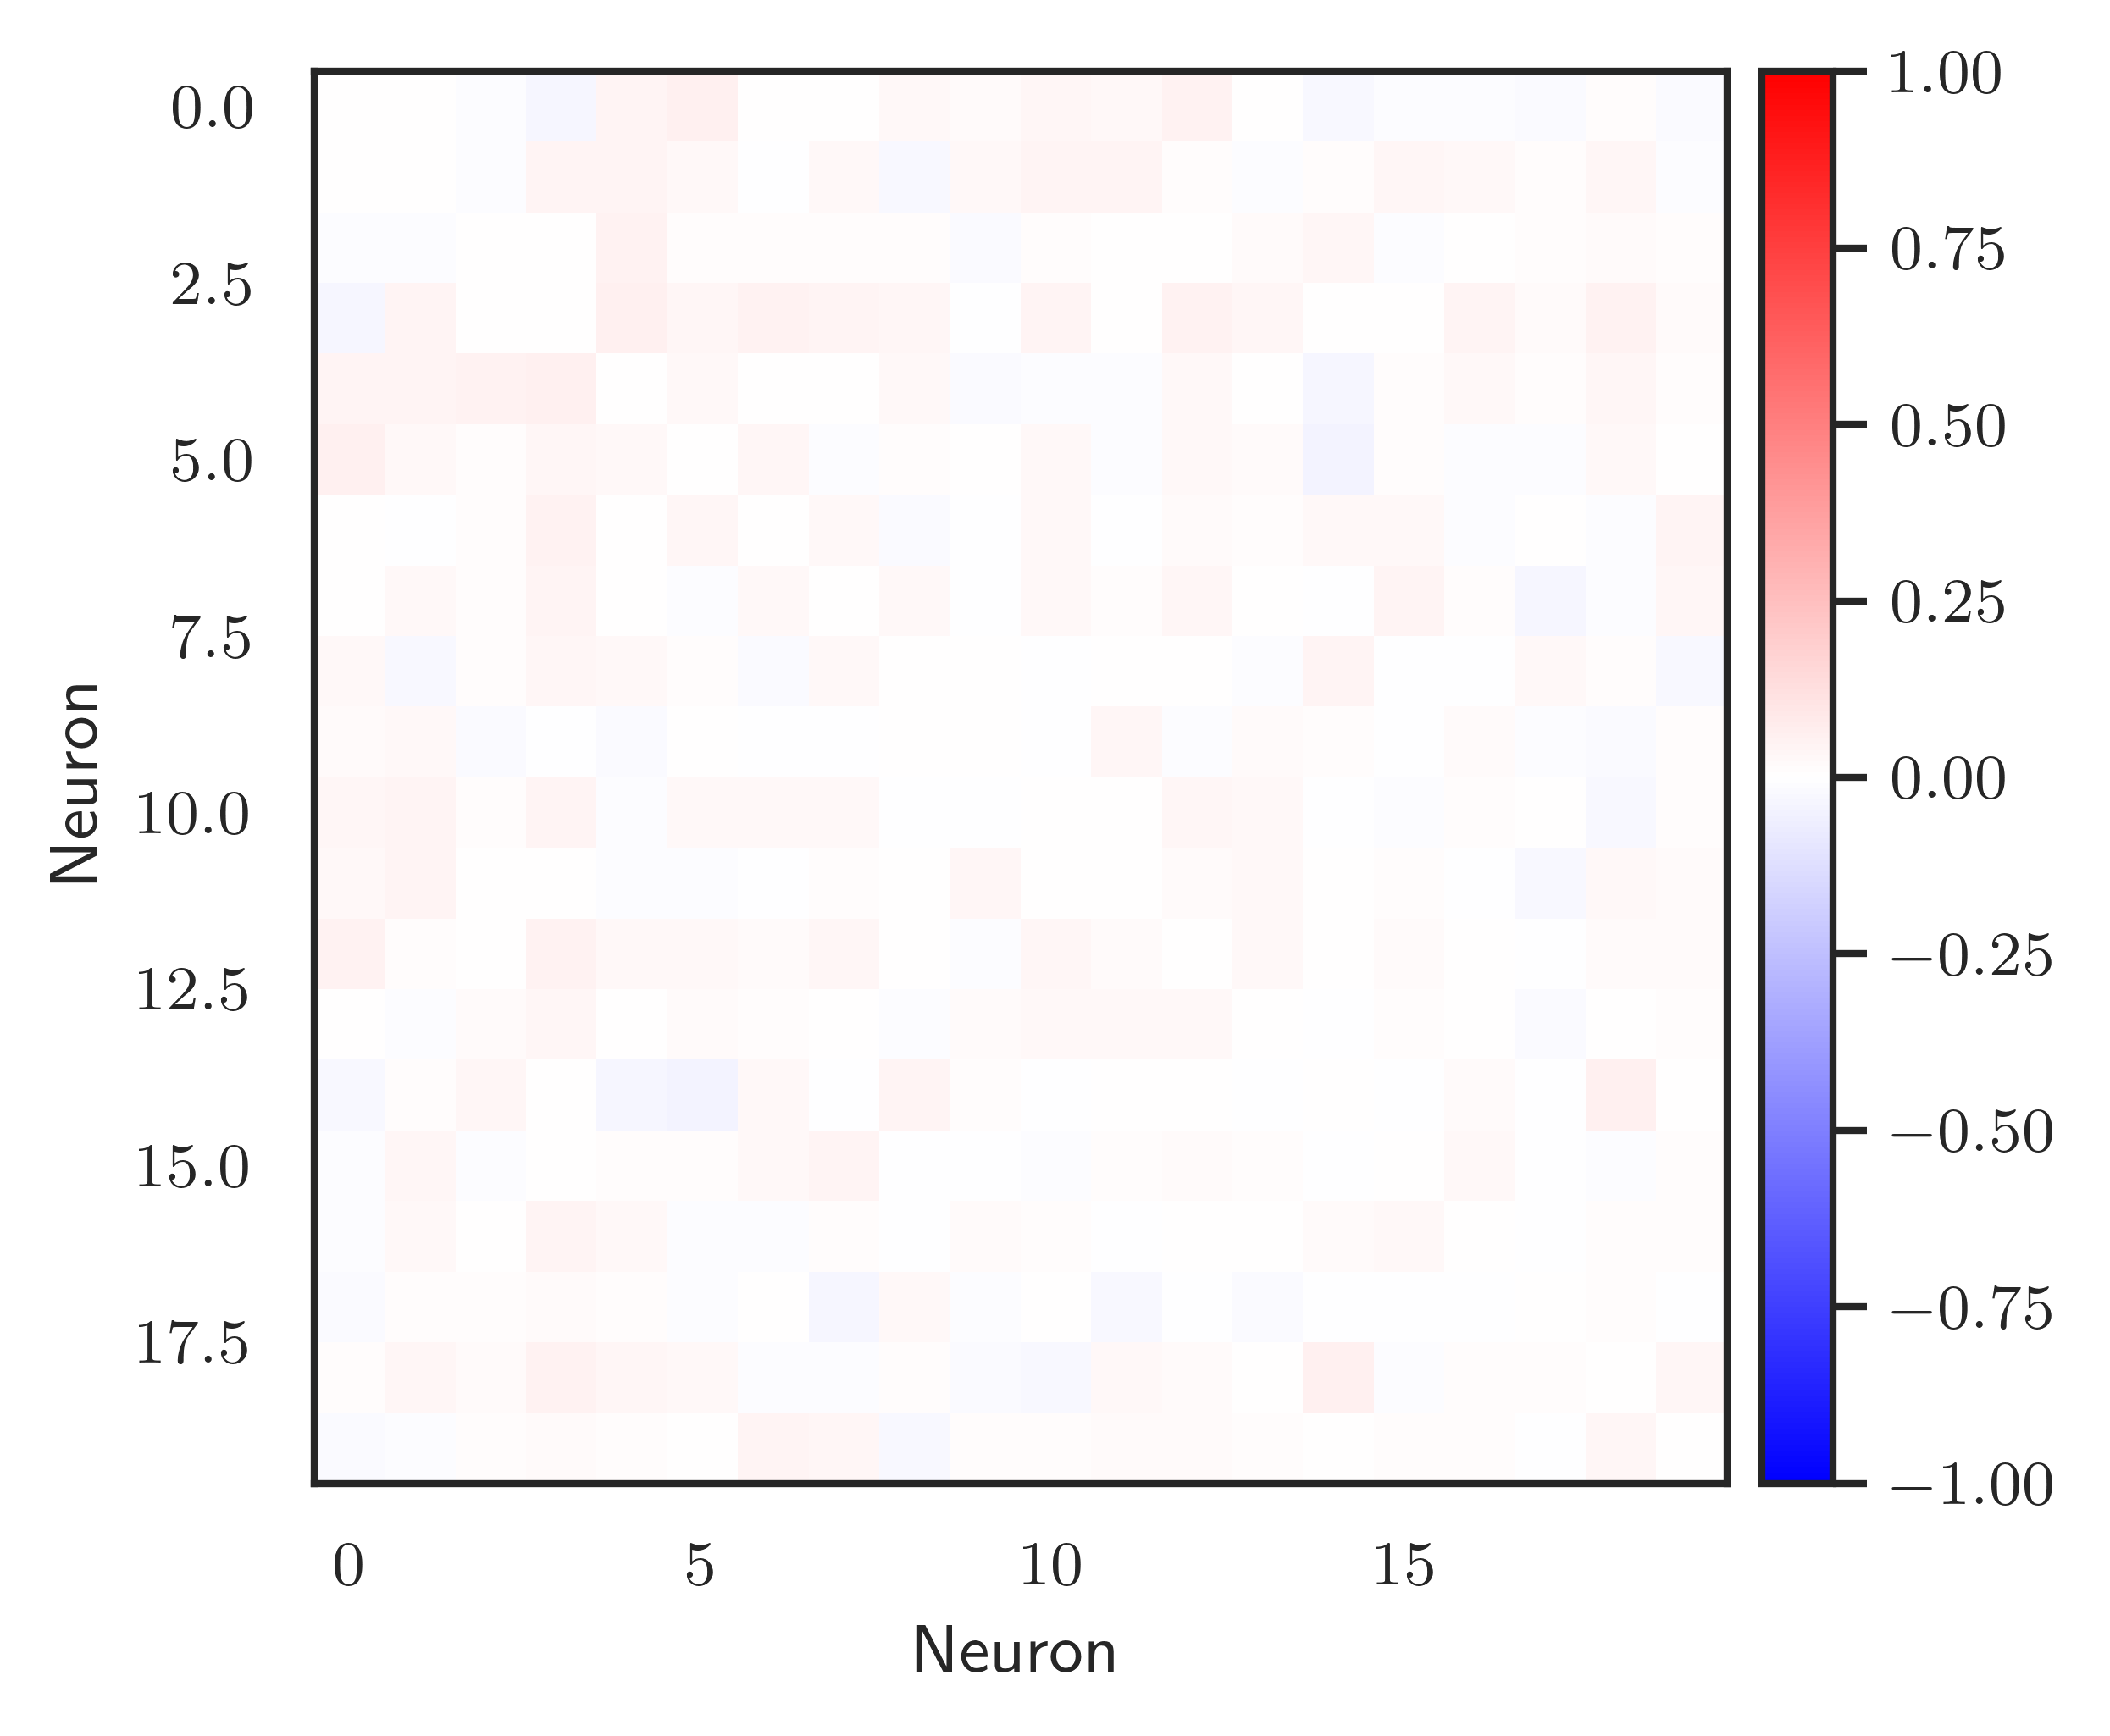

In [40]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize=fs, tight_layout=True, dpi=300)

    plot_corrcoef(corr_pred_ai_mean, colormap='bwr', correlation_range='full', axes=ax)

    ax.set(xlabel='Neuron',
           ylabel='Neuron',
           )

    
    fig.savefig(fig_path('brunel_pred_corr_sbi_ai.pdf'), 
                format='pdf', 
                dpi=300, 
                bbox_inches='tight'
               )

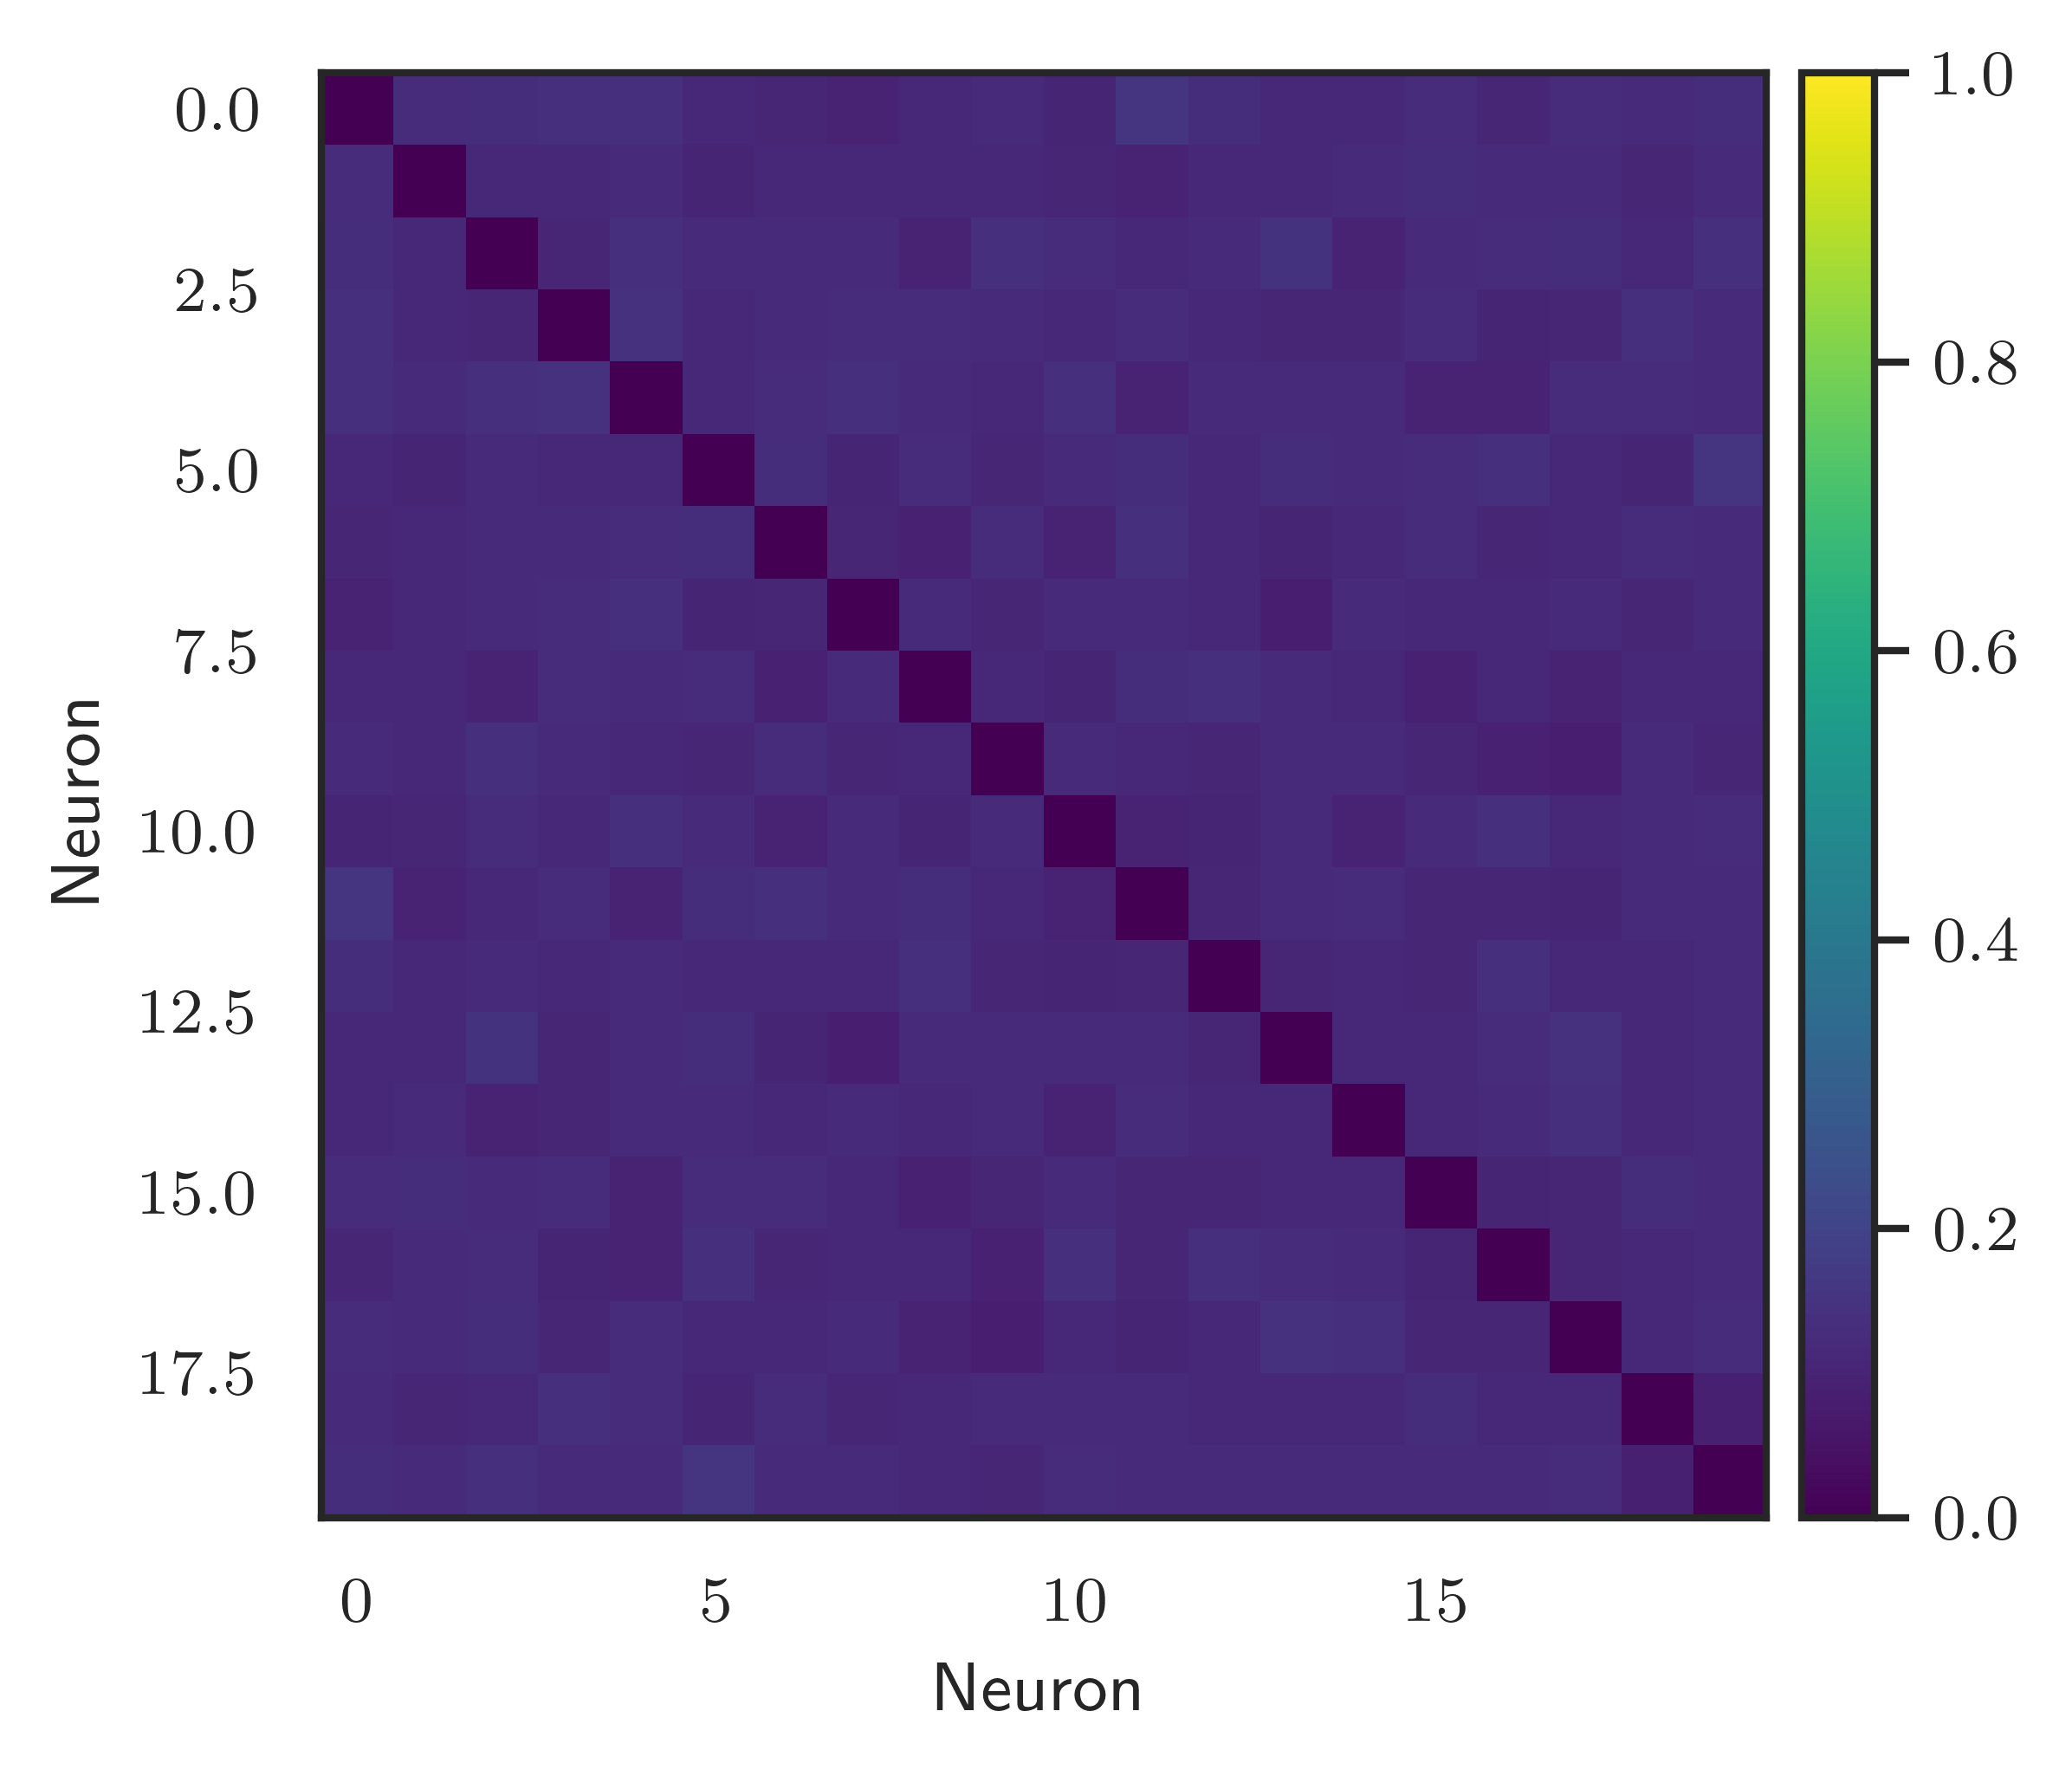

In [41]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize=fs, tight_layout=True, dpi=300)

    plot_corrcoef(corr_pred_ai_std, colormap='viridis', correlation_range=(0., 1.), axes=ax)

    ax.set(xlabel='Neuron',
           ylabel='Neuron',
           )

     
    fig.savefig(fig_path('brunel_pred_corr_std_ai_sbi.pdf'), 
                format='pdf', 
                dpi=300, 
                bbox_inches='tight'
               )

## Observation II: SR state

In [27]:
g_sr = 3.   
eta_sr = 2. 

spiketrains_sr = bnet(eta=eta_sr, g=g_sr)

s_obs_sr = sts(spiketrains_sr)

df_obs_sr = pd.DataFrame(np.array([s_obs_sr]),
                      columns=['Mean firing rate', 'Mean CV', 'Fano factor'])

df_obs_sr.insert(0, r"$\eta$", [2.])
df_obs_sr.insert(1, r"$g$", [3.])
df_obs_sr

,$\eta$,$g$,Mean firing rate,Mean CV,Fano factor
0,2.0,3.0,0.333278,0.012106,0.000724


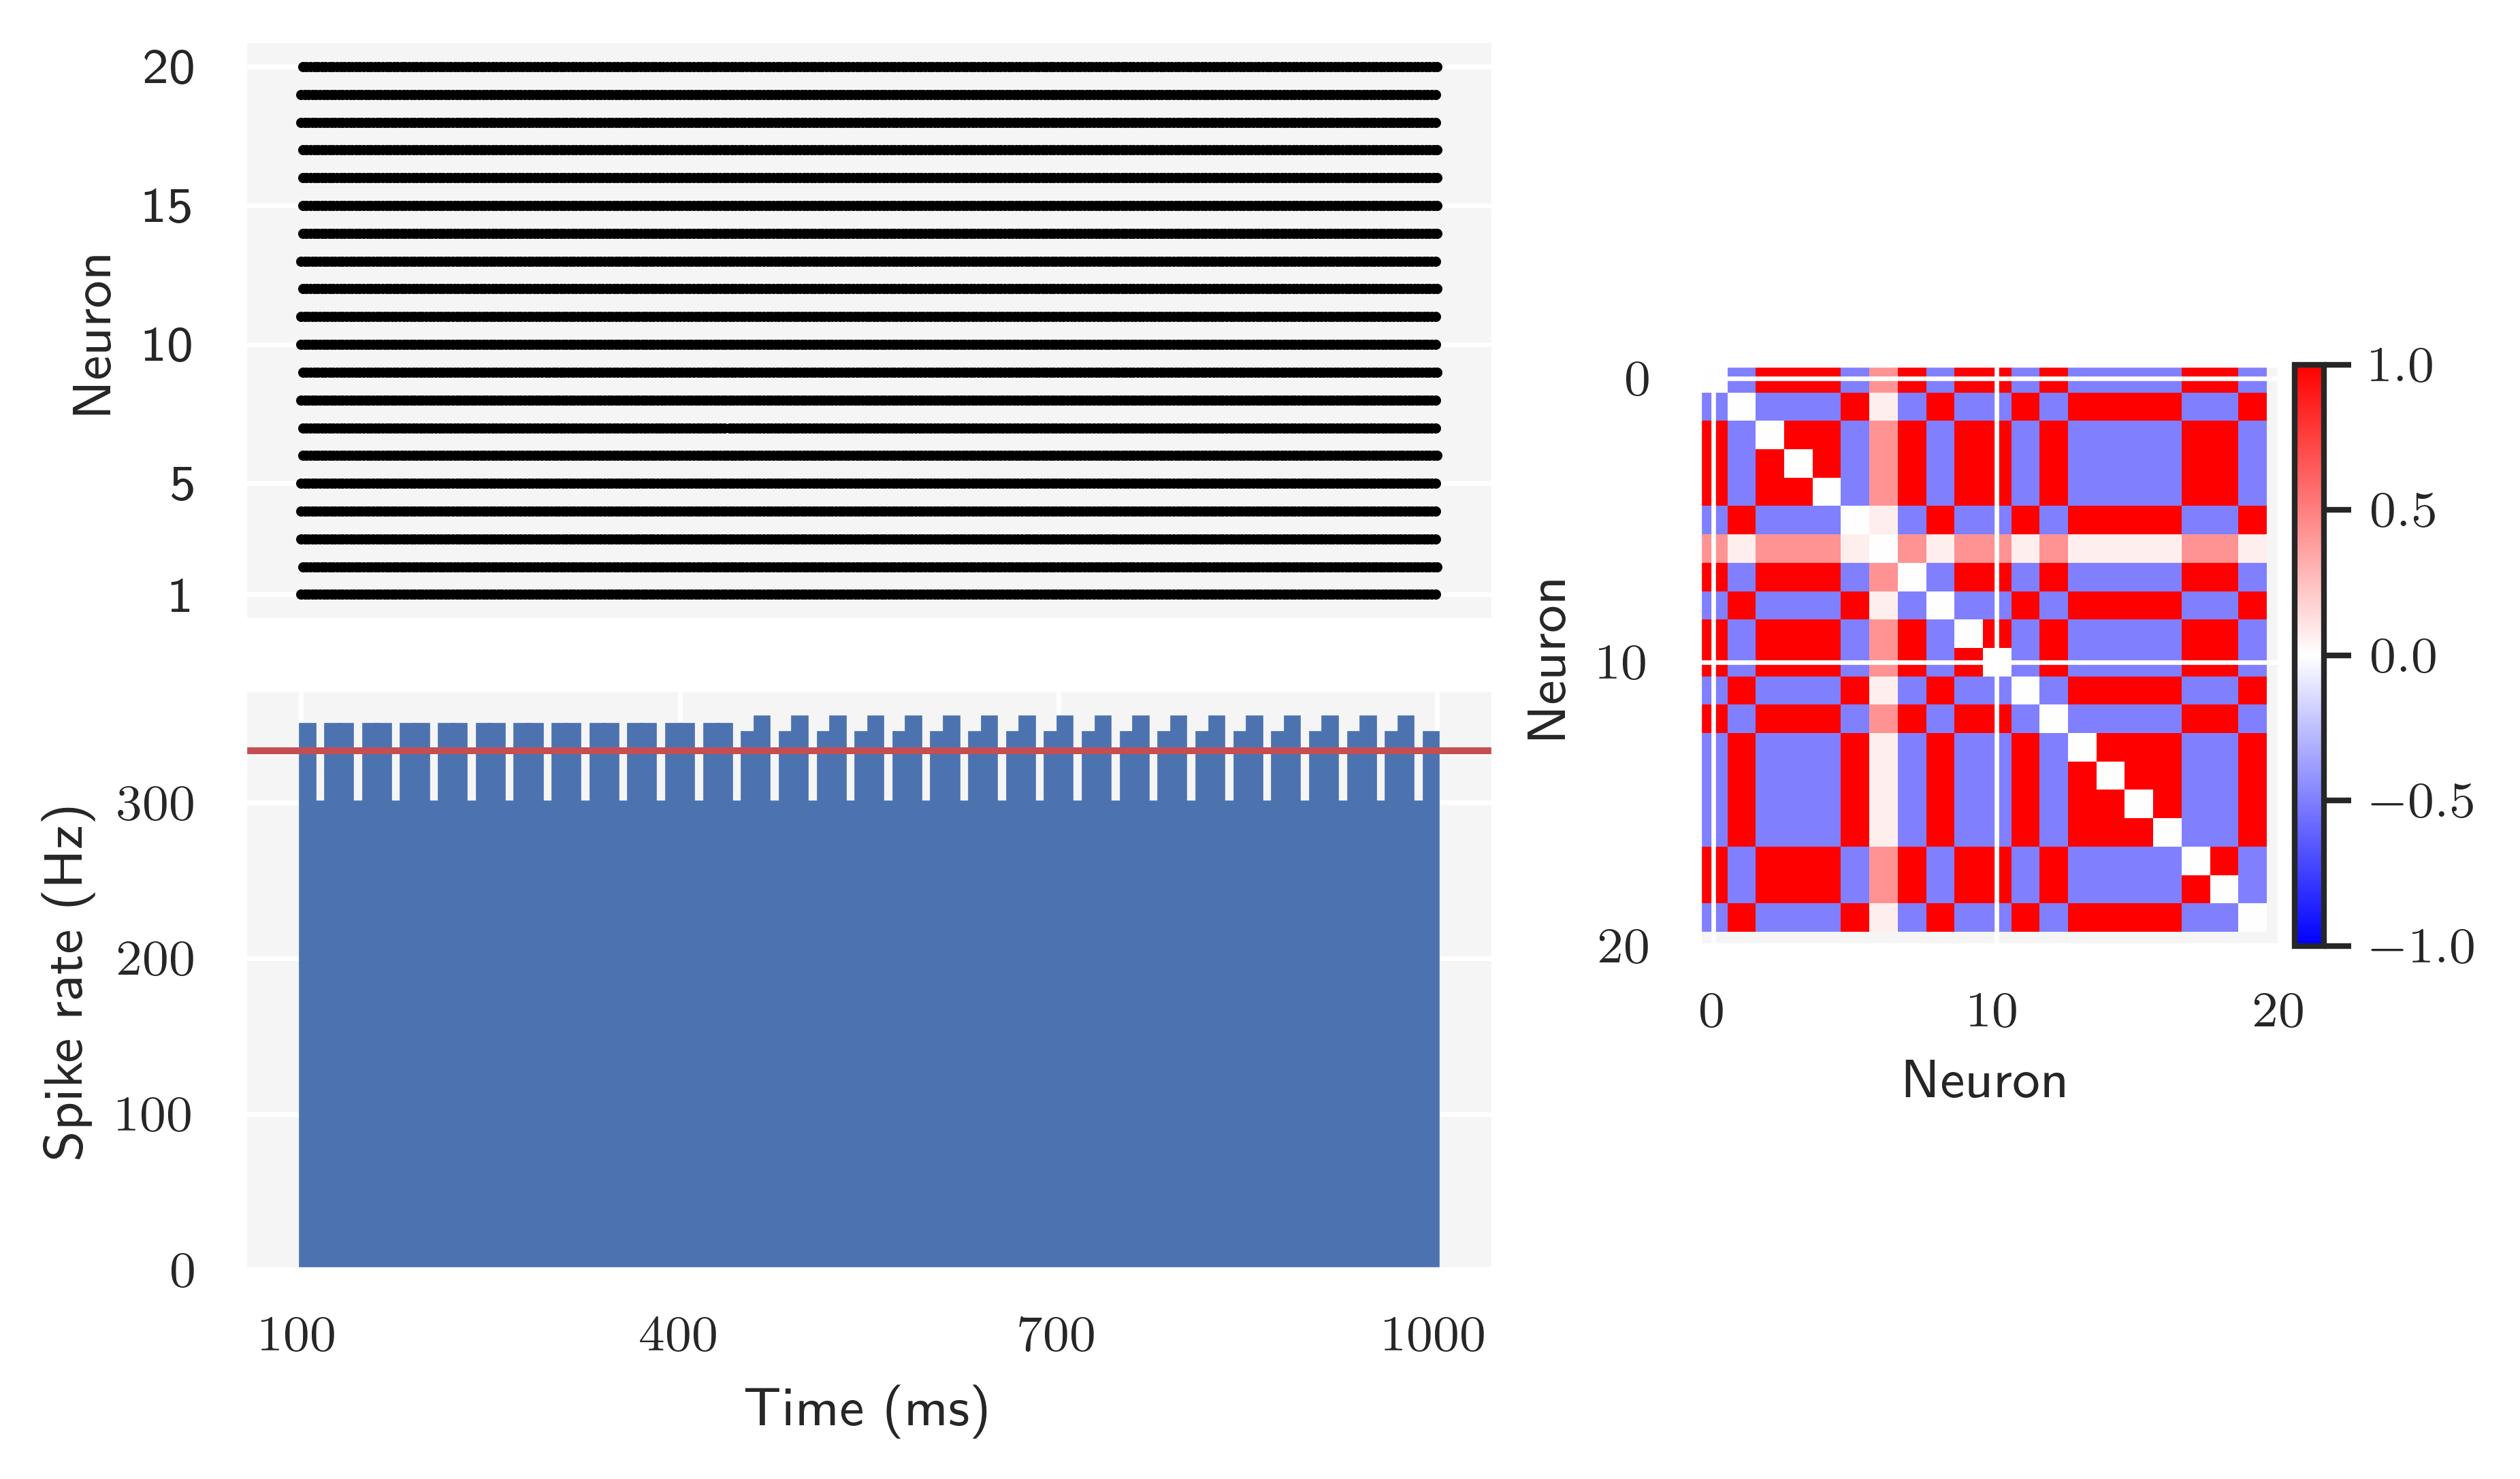

In [60]:
sns.set(context="paper", style='darkgrid', rc={"axes.facecolor": "0.96"})
fig = plt.figure(figsize=fs, constrained_layout=True, dpi=300)
gs = fig.add_gridspec(2, 2, width_ratios=[4, 2])

# computations
t_start = 100. * pq.ms
t_stop = T * pq.ms
spiketrains_slice = slice_spiketrains(spiketrains_sr, t_start=t_start, t_stop=t_stop)
hist = statistics.time_histogram(spiketrains_slice, bin_size=10 * pq.ms, output='rate')
mean_frate = sts.mean_firing_rate(spiketrains_slice, units=1 / pq.ms)
binned_spiketrains = BinnedSpikeTrain(spiketrains_slice, bin_size=10 * pq.ms)
corrcoef_matrix = correlation_coefficient(binned_spiketrains)


# rasterplot
ax1 = fig.add_subplot(gs[0, :-1])
rasterplot(spiketrains_slice, s=1, c='black', axes=ax1)
ax1.set(yticks=[0, 4, 9, 14, 19], yticklabels=[1, 5, 10, 15, 20], xticks=[], ylabel='Neuron', xlabel='')

# rate plot 
ax2 = fig.add_subplot(gs[1, :-1])
ax2.bar(hist.times,
          hist.magnitude.flatten() * 1000,
          width=hist.sampling_period, 
          color='C0',
          edgecolor='C0',
          align='edge',
          alpha=1
         )
ax2.axhline(mean_frate * 1000, color='C3', ls='-')   
ax2.set(xticks=[100, 400, 700, 1000], ylabel='Spike rate (Hz)', xlabel='Time (ms)') 

# correlation
ax3 = fig.add_subplot(gs[0:, -1])
with sns.axes_style("white"):

    plot_corrcoef(corrcoef_matrix, colormap='bwr', correlation_range='full', axes=ax3)
    ax3.set(xticks=[0, 10, 20], yticks=[0, 10, 20], xlabel='Neuron', ylabel='Neuron')
    
fig.savefig(fig_path('brunel_sr_observation.pdf'), 
            format='pdf', 
            dpi=300,
            bbox_inches='tight'
           )

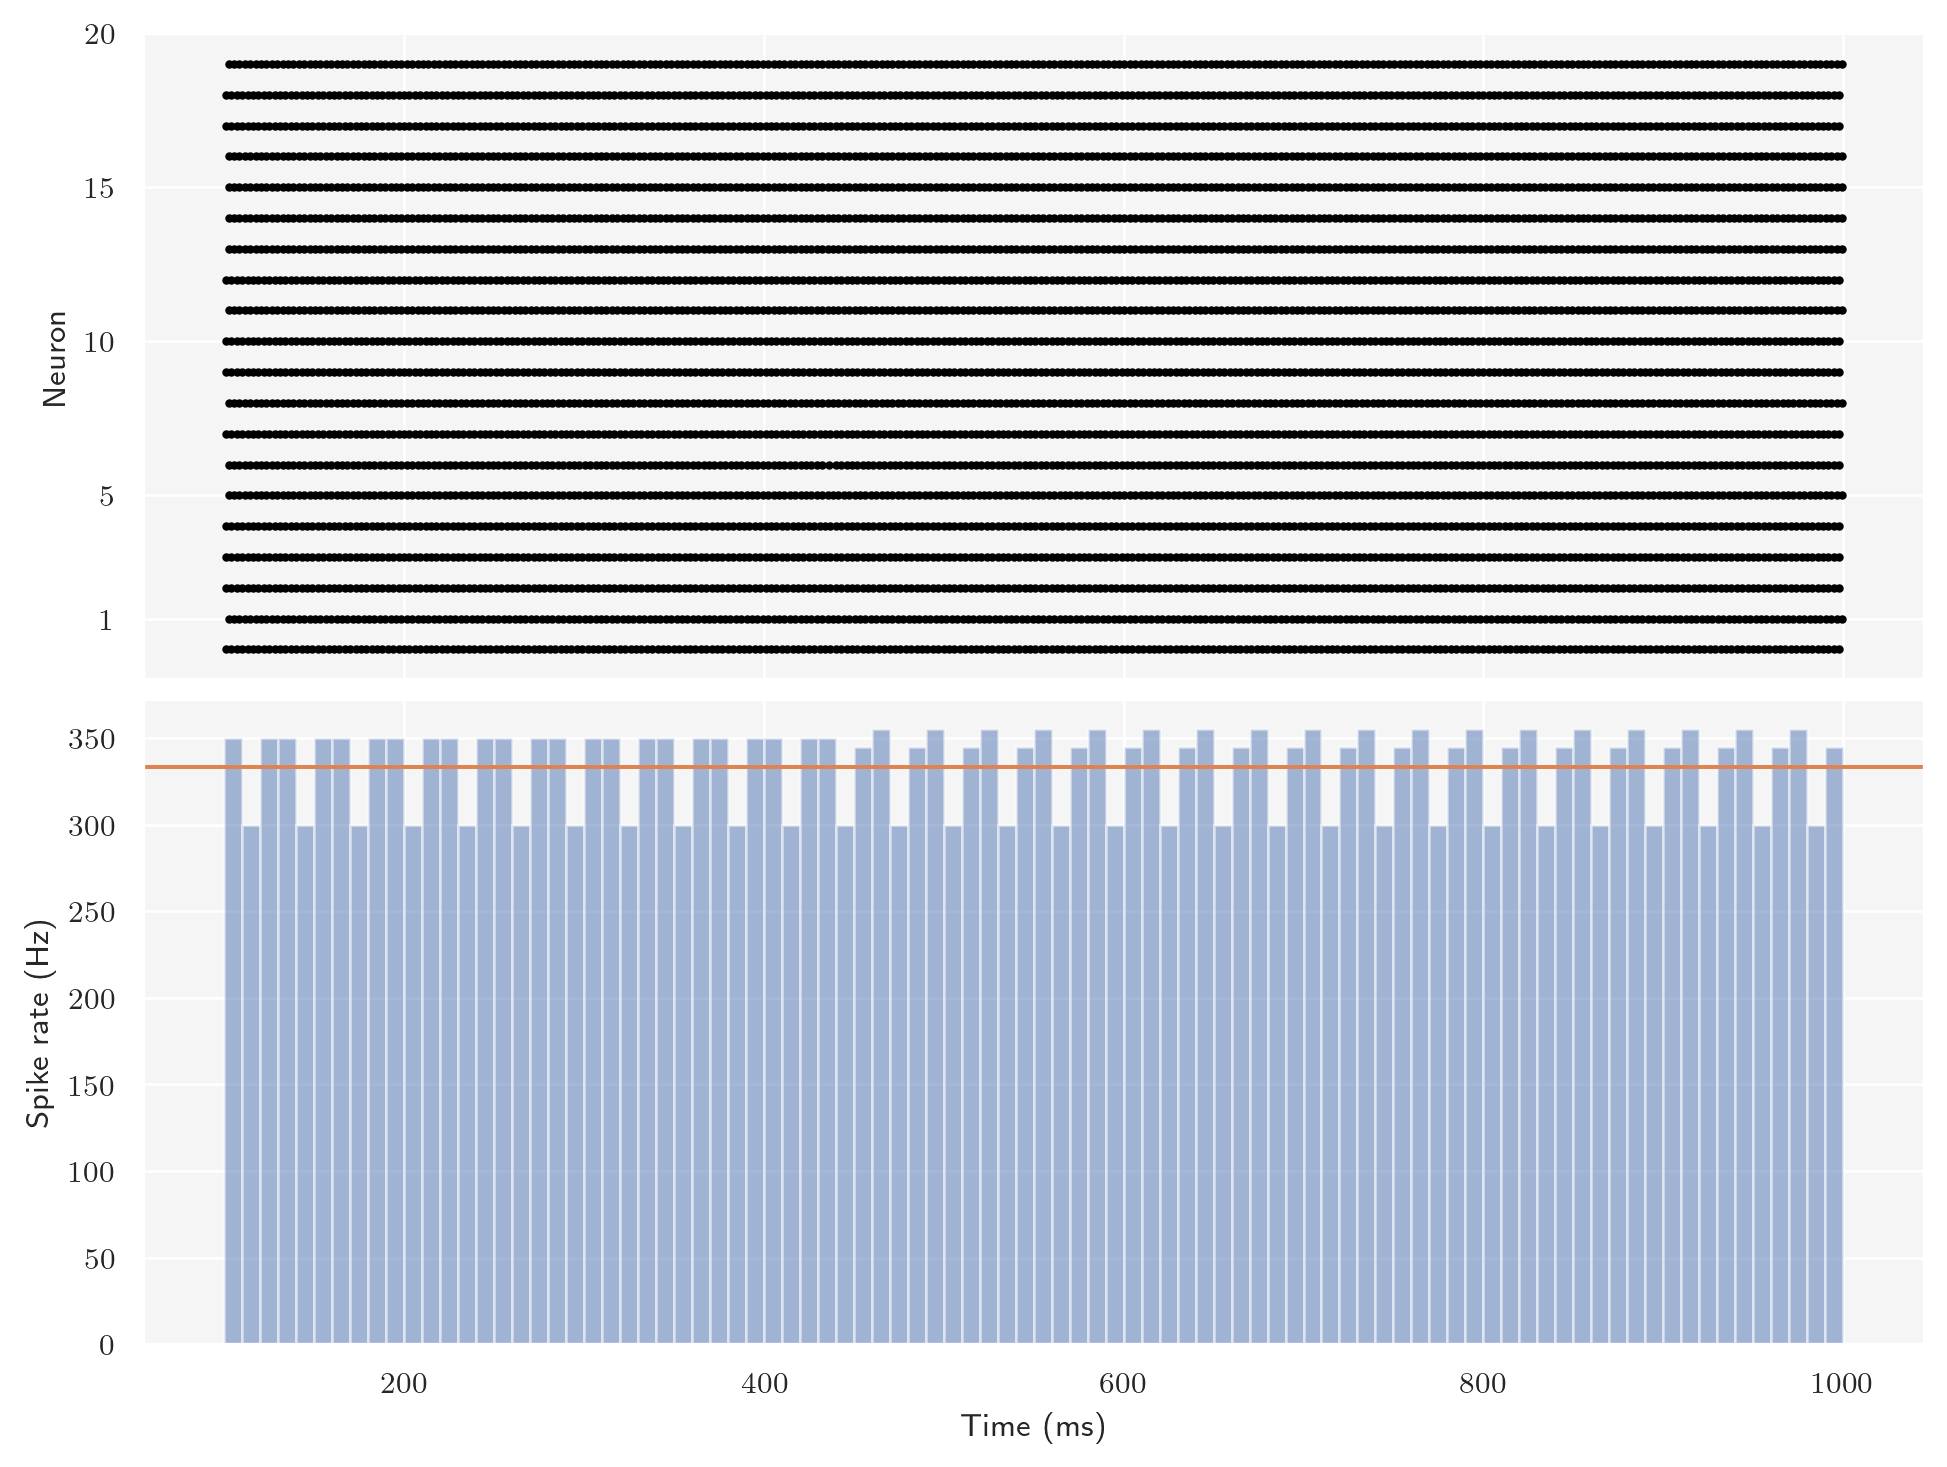

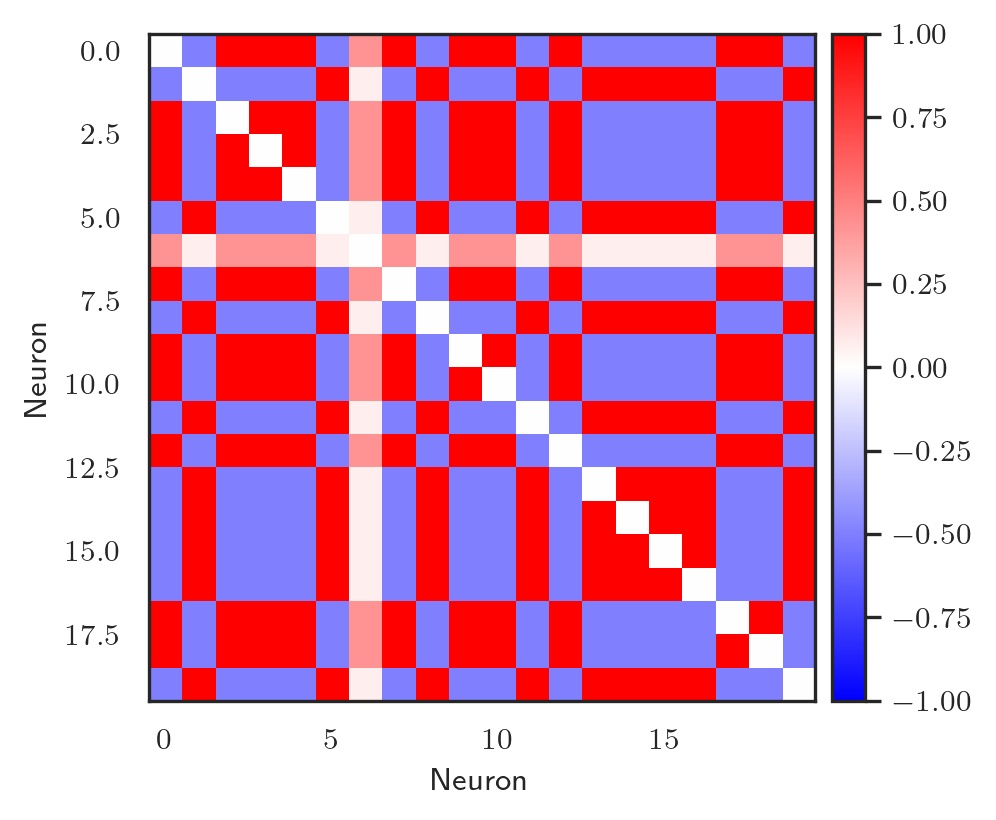

In [29]:
sns.set(context="paper", style='darkgrid', rc={"axes.facecolor": "0.96"})

t_start = 100. * pq.ms
t_stop = T * pq.ms

spiketrains_sr_slice = slice_spiketrains(spiketrains_sr,
                                         t_start=t_start,
                                         t_stop=t_stop
                                         )

hist_sr = statistics.time_histogram(spiketrains_sr_slice, bin_size=10 * pq.ms, output='rate')

mean_frate_sr = sts.mean_firing_rate(spiketrains_sr_slice, units=1 / pq.ms)

# Raster plot
fig, axes = plt.subplots(nrows=2, 
                         ncols=1,
                         figsize=(8, 6),
                         constrained_layout=True,
                         dpi=120,
                         sharex=True
                       )

rasterplot(spiketrains_sr_slice, s=3, c='black', axes=axes[0])

axes[0].set(yticks=[1, 5, 10, 15, 20],
            ylabel='Neuron',
            xlabel=''
           ) 

# Rate plot
axes[1].bar(hist_sr.times, 
            hist_sr.magnitude.flatten() * 1000, 
            width=hist_sr.sampling_period, 
            align='edge', 
            alpha=0.5)

axes[1].axhline(mean_frate_sr * 1000, color='C1')        

axes[1].set(ylabel='Spike rate (Hz)',
            xlabel='Time (ms)'
           ) 

# Correlation coefficient matrix
binned_spiketrains_sr = BinnedSpikeTrain(spiketrains_sr_slice, bin_size=10 * pq.ms)
corrcoef_matrix_sr = correlation_coefficient(binned_spiketrains_sr)

with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize=fs, tight_layout=True, dpi=120)

    plot_corrcoef(corrcoef_matrix_sr, colormap='bwr', correlation_range='full', axes=ax)

    ax.set(xlabel='Neuron',
           ylabel='Neuron',
           )
    
plt.show()

In [30]:
thetas_sr = posterior.sample((1000,), x=s_obs_sr)

param_names =  [r'$\eta$', r'$g$']
data_sr = dict(zip(param_names, np.stack(thetas_sr, axis=-1)))
df_sr = pd.DataFrame.from_dict(data_sr)
df_sr

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

,$\eta$,$g$
0,1.854958,2.605677
1,2.507373,1.839687
2,3.279296,2.801780
3,1.845107,2.233902
4,1.583449,1.847205
...,...,...
995,3.318974,1.843570
996,1.903617,3.105779
997,3.801393,2.275403
998,1.779098,2.965570


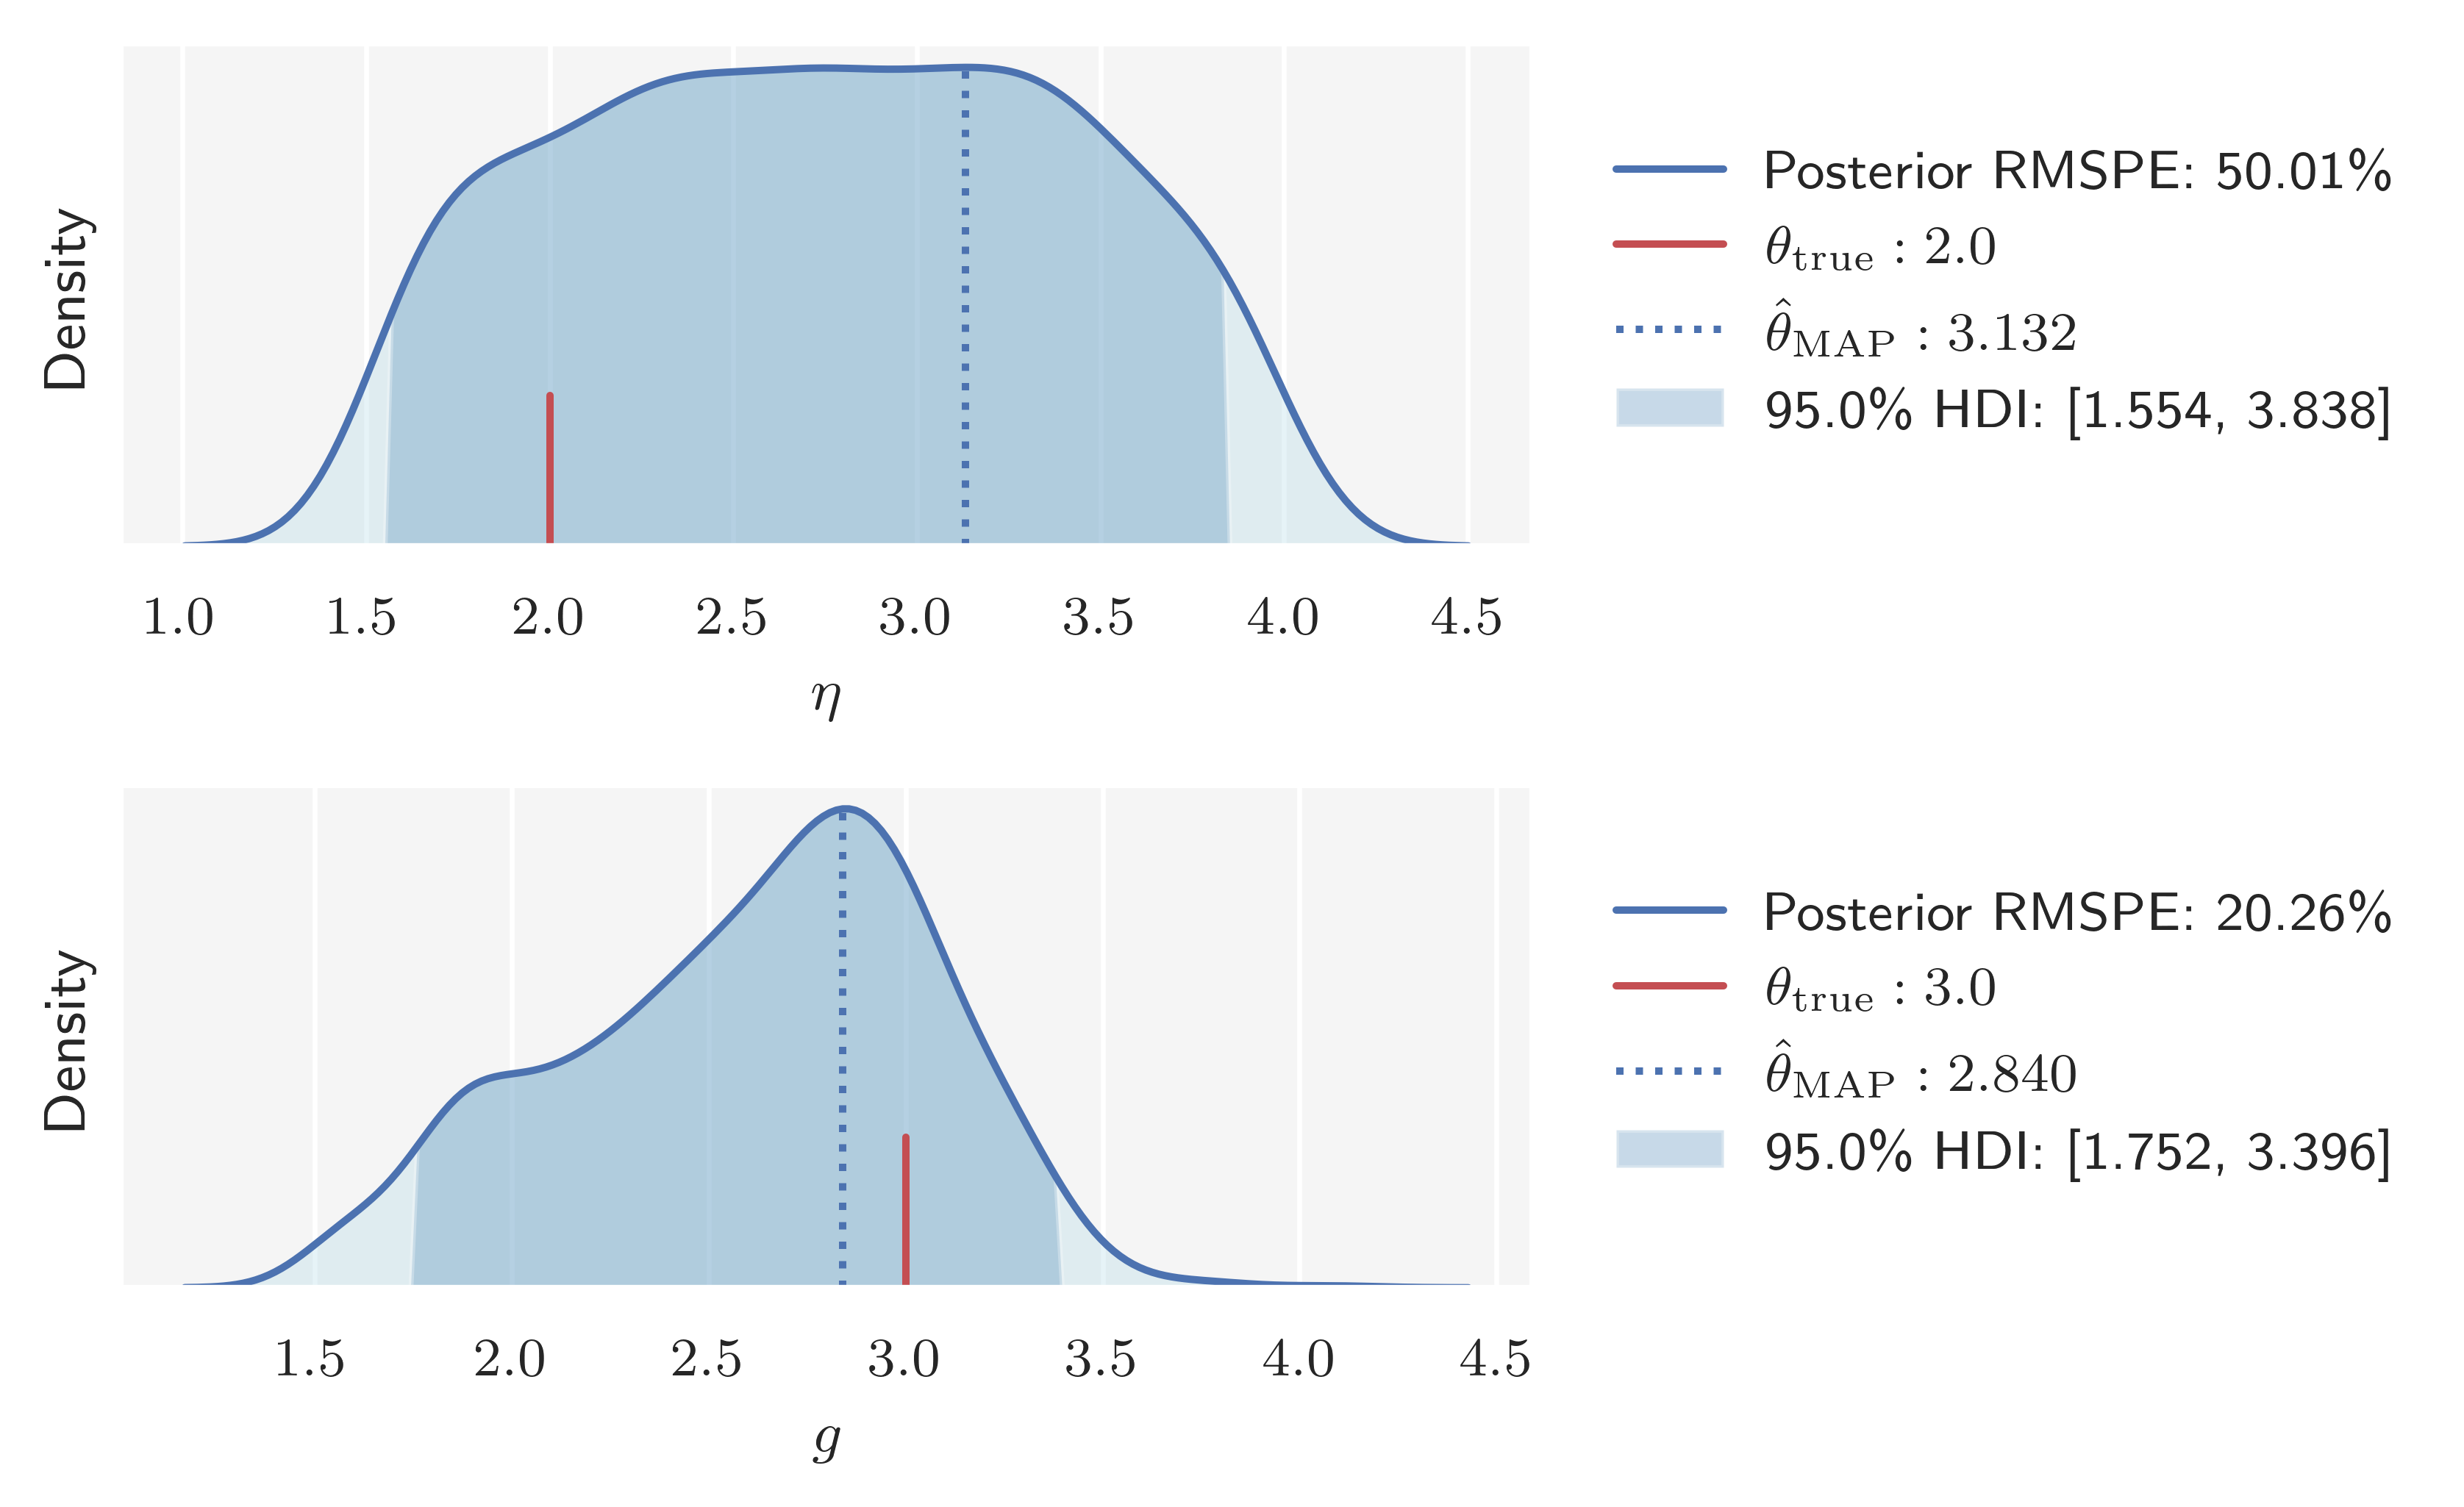

In [42]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=fs, tight_layout=True, dpi=300)
plot_posterior(df_sr, r'$\eta$', point_estimate='map', theta_true=eta_sr, ax=axes[0])
plot_posterior(df_sr, r'$g$', point_estimate='map', theta_true=g_sr, ax=axes[1])

fig.savefig(fig_path('brunel_post_sr_sbi.pdf'), 
            format='pdf', 
            dpi=300,
            bbox_inches='tight'
           )

In [32]:
size = 50
idxs = np.random.randint(0, len(df_sr.index), size)
thetas_pred_sr = df_sr.iloc[idxs].to_numpy()

s_stats_pred_sr = []
corr_pred_sr = []

for thetas_ in thetas_pred_sr:
    spiketrains_pred_sr = bnet(*thetas_)
    s_stats_pred_i_sr = sts(spiketrains_pred_sr)
    s_stats_pred_sr.append(s_stats_pred_i_sr)
    
    spiketrains_pred_sr_slice = slice_spiketrains(spiketrains_pred_sr,
                                                  t_start=t_start,
                                                  t_stop=t_stop
                                                 )
    
    binned_spiketrains_pred_sr = BinnedSpikeTrain(spiketrains_pred_sr_slice, bin_size=10 * pq.ms)
    corrcoef_matrix_pred_sr = correlation_coefficient(binned_spiketrains_pred_sr)
    corr_pred_sr.append(corrcoef_matrix_pred_sr)
    
    
data_pred_sr = dict(zip(s_stats, np.stack(s_stats_pred_sr, axis=-1)))
df_pred_sr = pd.DataFrame.from_dict(data_pred_sr)
df_pred_sr.insert(0, r"$\eta$", thetas_pred_sr[:, 0])
df_pred_sr.insert(1, r"$g$", thetas_pred_sr[:, 1])

df_pred_sr.rename(columns={"mean_firing_rate": "Mean firing rate",
                           "mean_cv": "Mean CV",
                           "fanofactor": "Fano factor"
                          },
                  inplace=True
                 )

df_pred_sr

,$\eta$,$g$,Mean firing rate,Mean CV,Fano factor
0,3.174397,2.889822,0.333333,0.004816,0.000722
1,1.583449,1.847205,0.333333,0.010707,0.000746
2,1.751601,2.724445,0.333333,0.007975,0.000754
3,3.505217,2.880329,0.333333,0.006486,0.000722
4,2.290202,2.221859,0.333722,0.007342,0.000685
5,2.151286,2.826519,0.333333,0.007283,0.000482
6,3.543219,2.190117,0.333333,0.013499,0.000563
7,3.945514,2.776113,0.333333,0.007484,0.000631
8,3.730002,2.999709,0.333333,0.006597,0.000744
9,2.871425,3.182683,0.333222,0.017828,0.000987


In [33]:
eta_sr_mean = np.mean(thetas_pred_sr[:, 0])
g_sr_mean = np.mean(thetas_pred_sr[:, 1])
s_stats_sr_mean = np.mean(np.array(s_stats_pred_sr), axis=0)
df_pred_sr_mean = pd.DataFrame(np.array([s_stats_sr_mean]),
                               columns=['Mean firing rate', 'Mean CV', 'Fano factor']
                              )

df_pred_sr_mean.insert(0, r"$\eta$", [eta_sr_mean])
df_pred_sr_mean.insert(1, r"$g$", [g_sr_mean])

df_pred_sr_mean

,$\eta$,$g$,Mean firing rate,Mean CV,Fano factor
0,2.740838,2.652433,0.330699,0.013538,0.001185


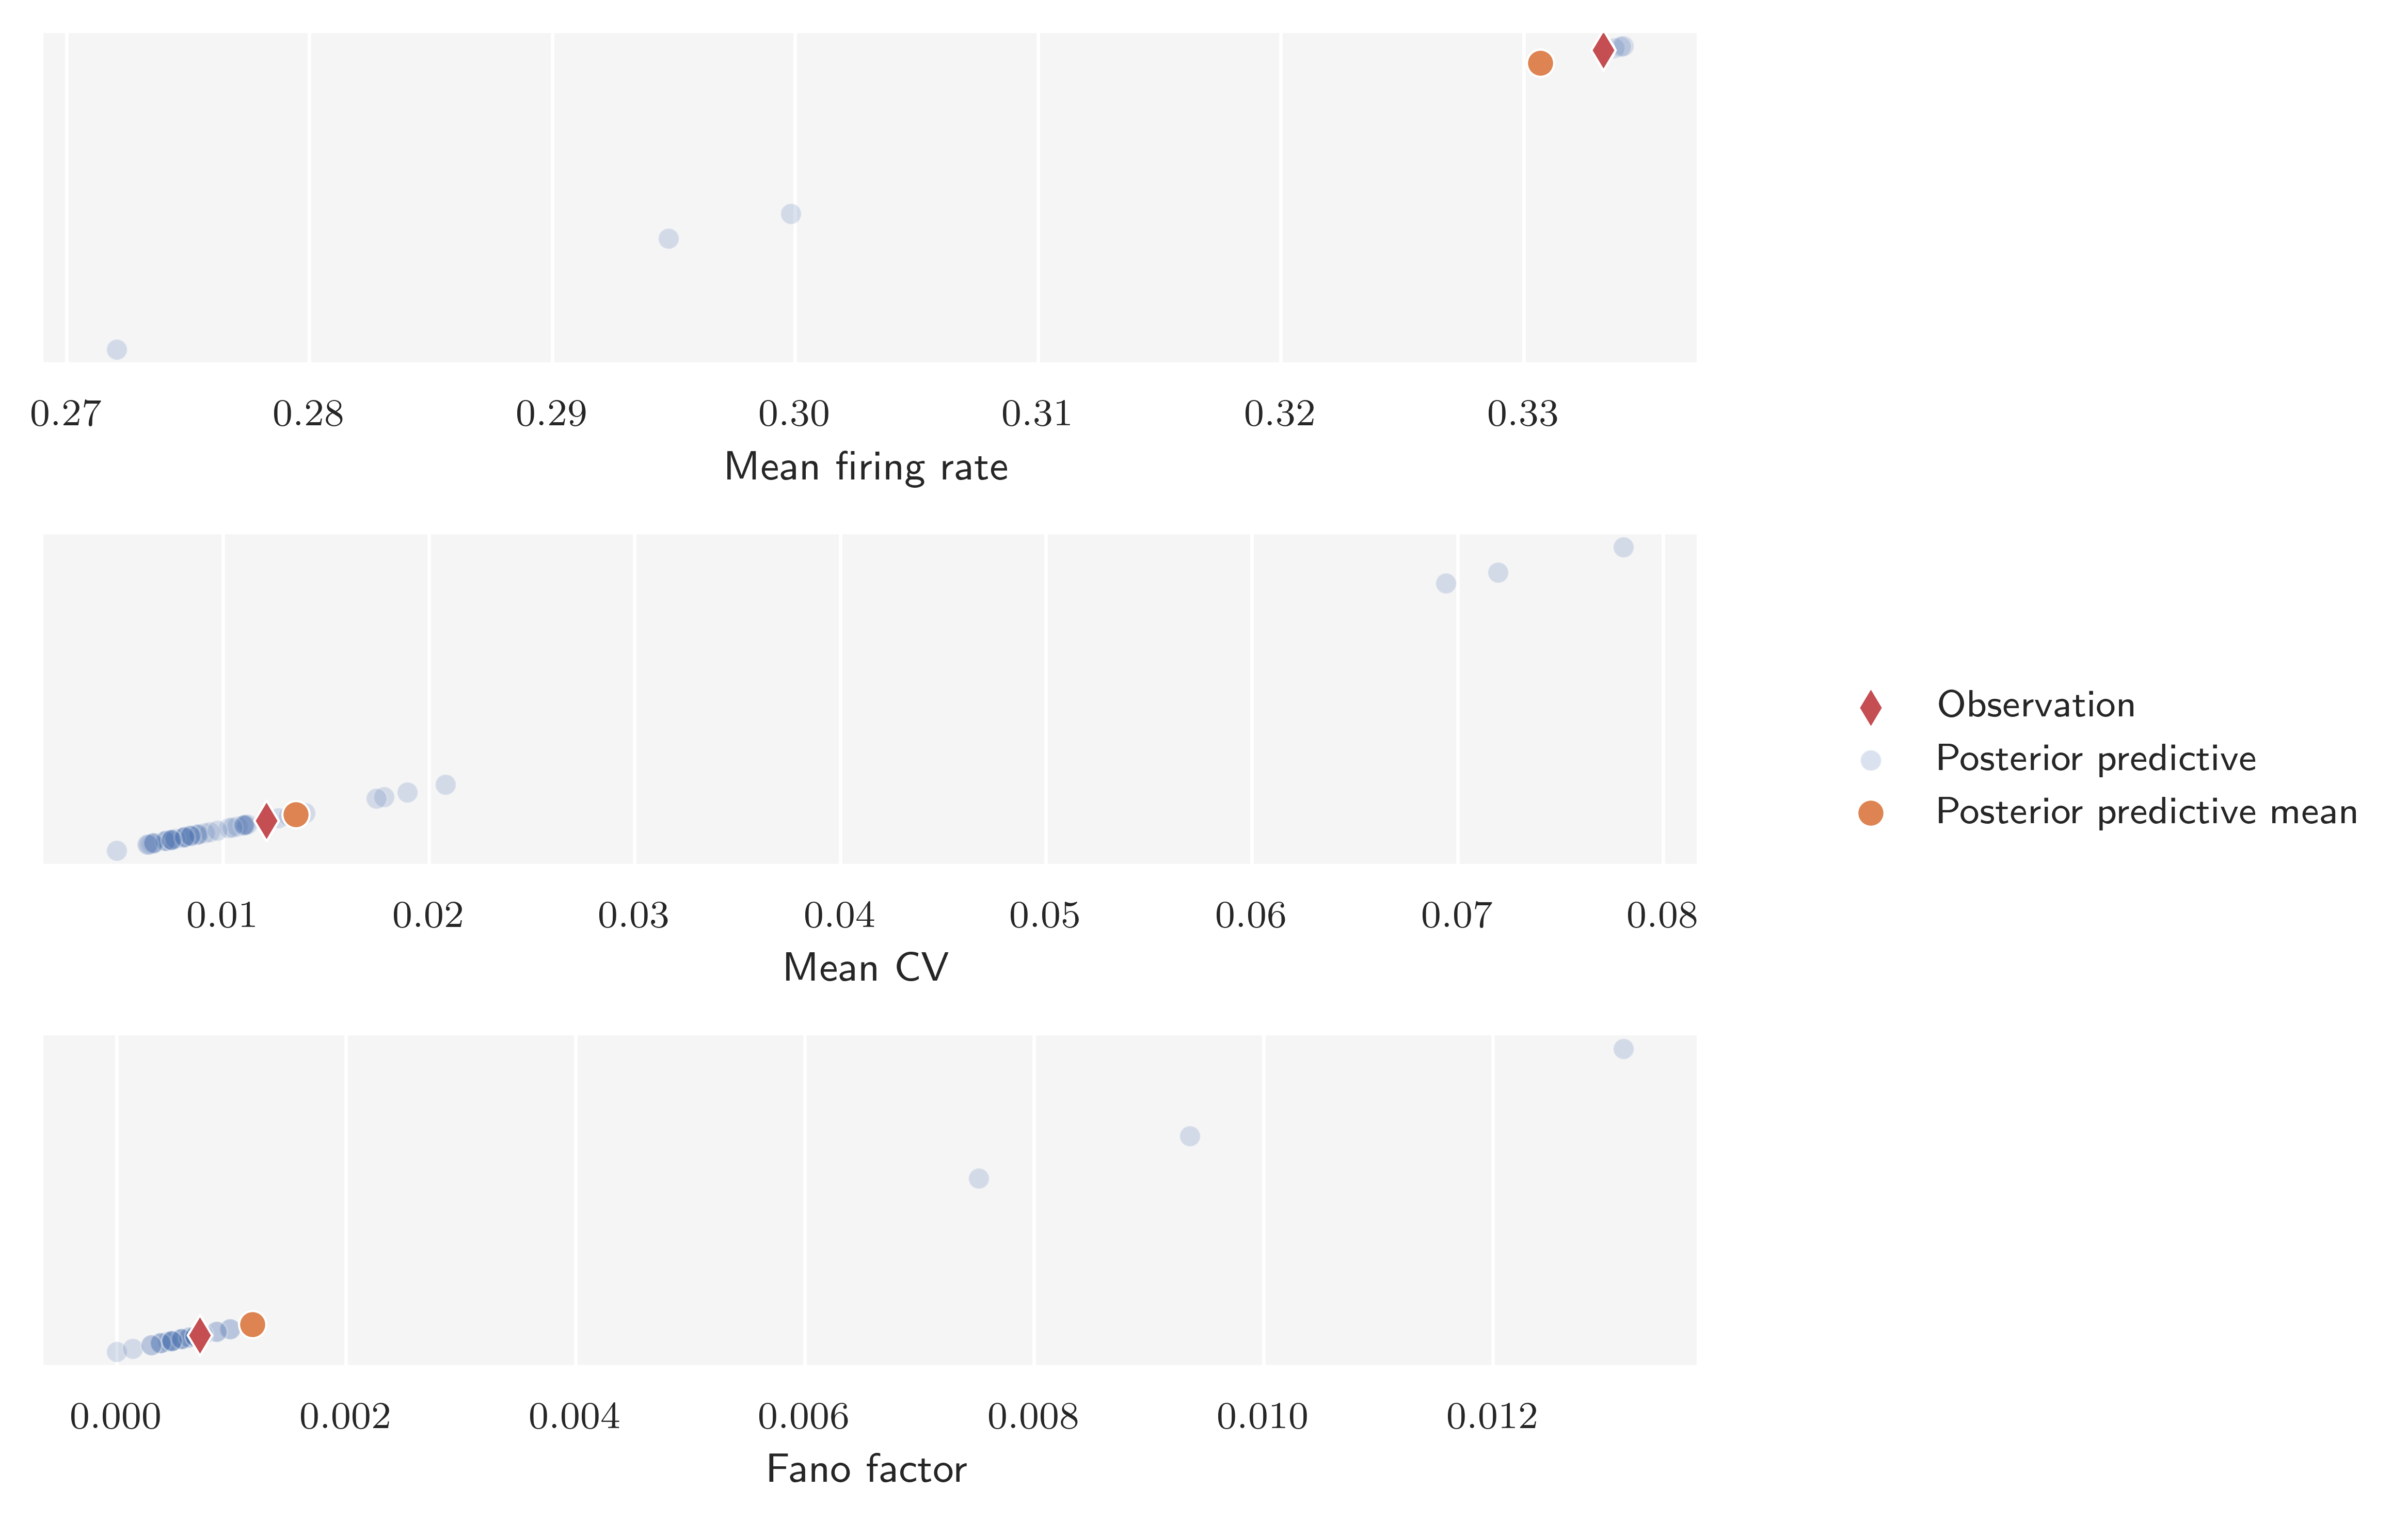

In [43]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(fs[0], 5), tight_layout=True, dpi=300)

# Mean firing rate
ax = axes[0]

sns.scatterplot(data=df_obs_sr, 
                x="Mean firing rate", 
                y="Mean firing rate", 
                color='r',
                marker='d',
                s=45,
                label='Observation',
                ax=ax,
                zorder=2
               )

sns.scatterplot(data=df_pred_sr, 
                x="Mean firing rate", 
                y="Mean firing rate", 
                color='C0',
                alpha=0.2,
                #s='d',
                label='Posterior predictive',
                ax=ax,
                zorder=1
               )

sns.scatterplot(data=df_pred_sr_mean, 
                x="Mean firing rate", 
                y="Mean firing rate", 
                color='C1',
                s=40,
                label='Posterior predictive mean',
                ax=ax,
                zorder=3
               )

ax.set(yticks=[],
       ylabel='')

# Mean CV
ax2 = axes[1]

sns.scatterplot(data=df_obs_sr, 
                x="Mean CV", 
                y="Mean CV", 
                color='r',
                marker='d',
                s=45,
                ax=ax2,
                zorder=2
               )

sns.scatterplot(data=df_pred_sr, 
                x="Mean CV", 
                y="Mean CV", 
                color='C0',
                alpha=0.2,
                ax=ax2,
                zorder=1
               )

sns.scatterplot(data=df_pred_sr_mean, 
                x="Mean CV", 
                y="Mean CV", 
                color='C1',
                s=40,
                ax=ax2,
                zorder=3
               )

ax2.set(yticks=[],
        ylabel='')

# Fano factor
ax3 = axes[2]

sns.scatterplot(data=df_obs_sr, 
                x="Fano factor", 
                y="Fano factor", 
                color='r',
                marker='d',
                s=45,
                ax=ax3,
                zorder=2
               )

sns.scatterplot(data=df_pred_sr, 
                x="Fano factor", 
                y="Fano factor", 
                color='C0',
                alpha=0.2,
                ax=ax3,
                zorder=1
               )

sns.scatterplot(data=df_pred_sr_mean, 
                x="Fano factor", 
                y="Fano factor", 
                color='C1',
                s=40,
                ax=ax3,
                zorder=3
               )

ax3.set(yticks=[],
        ylabel='')

# legend

handles, labels = ax.get_legend_handles_labels()

fig.legend(
    handles,
    labels,
    loc='center left',
    bbox_to_anchor=(1.04, 0.5),
    fancybox=True,
    borderaxespad=0.1,
    ncol=1,
    frameon=False
)

ax.legend([], [], frameon=False)


fig.savefig(fig_path('brunel_post_pred_sr_sbi.pdf'), 
                format='pdf', 
                dpi=300, 
                bbox_inches='tight'
               )


In [35]:
corr_pred_sr = np.array(corr_pred_sr)
corr_pred_sr_mean = np.mean(corr_pred_sr, axis=0)
corr_pred_sr_std = np.std(corr_pred_sr, axis=0)

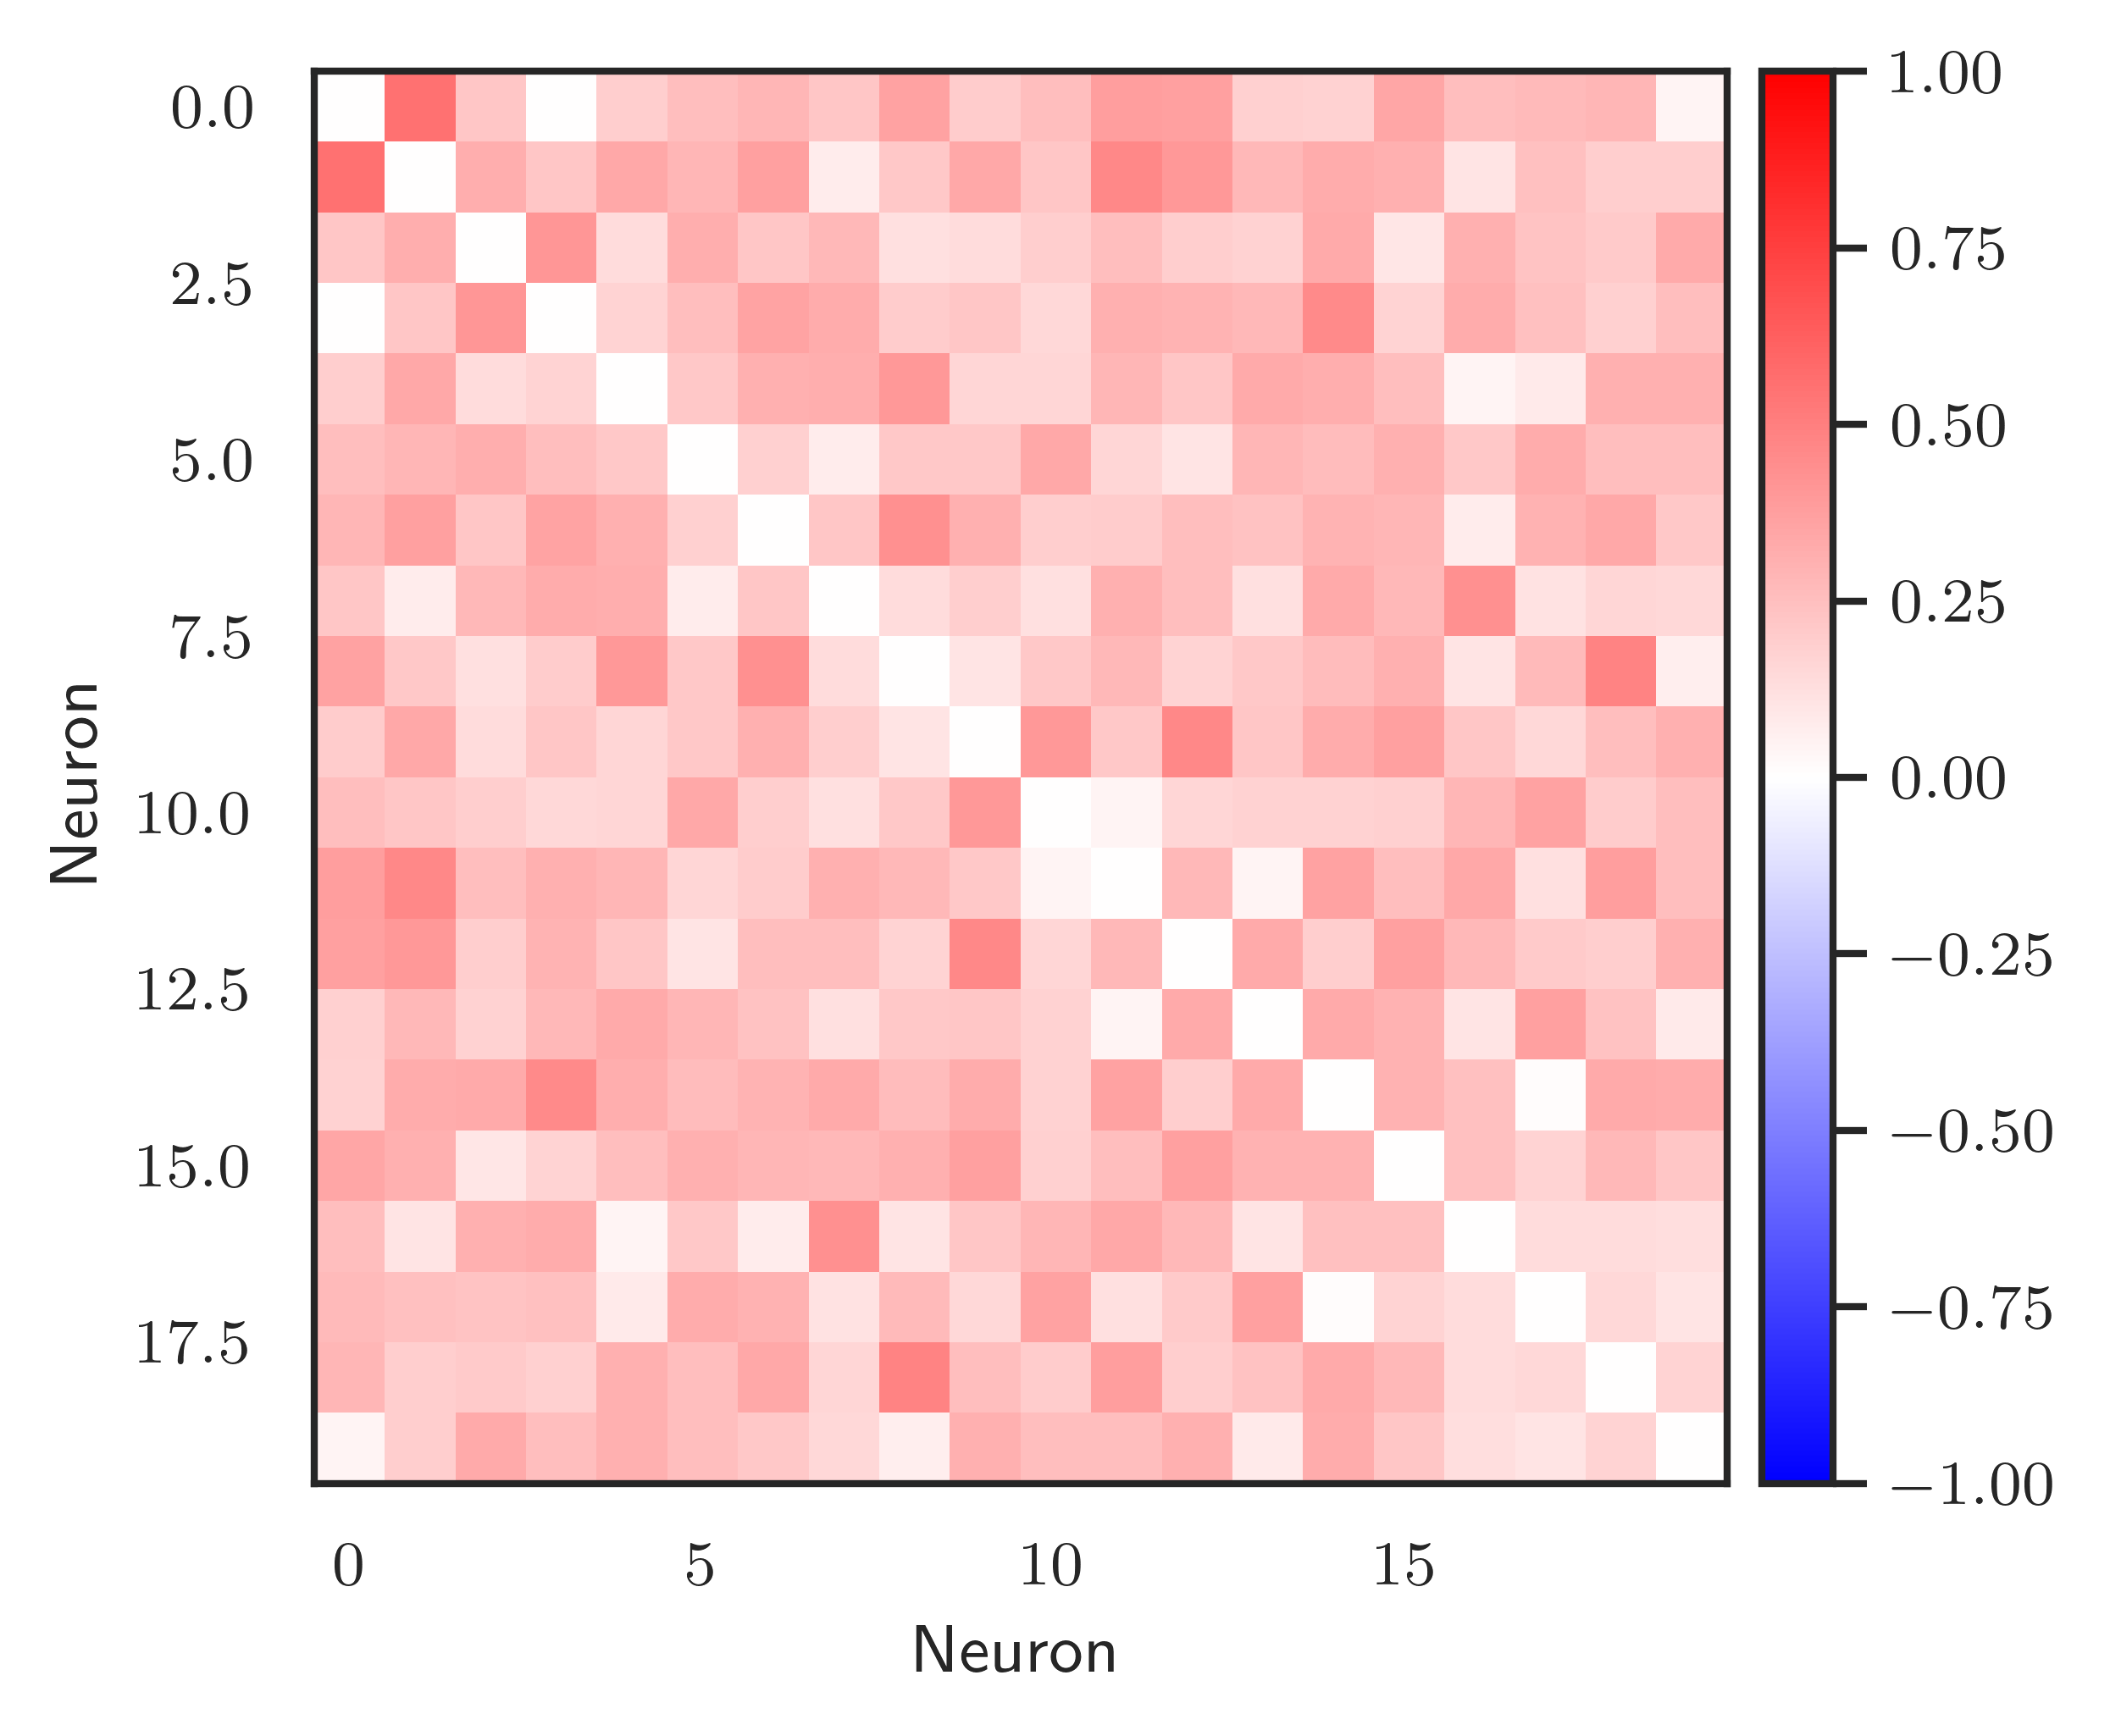

In [44]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize=fs, tight_layout=True, dpi=300)

    plot_corrcoef(corr_pred_sr_mean, colormap='bwr', correlation_range='full', axes=ax)

    ax.set(xlabel='Neuron',
           ylabel='Neuron',
           )

    
    fig.savefig(fig_path('brunel_pred_corr_sbi_sr.pdf'), 
                format='pdf', 
                dpi=300, 
                bbox_inches='tight'
               )
    
    plt.show()

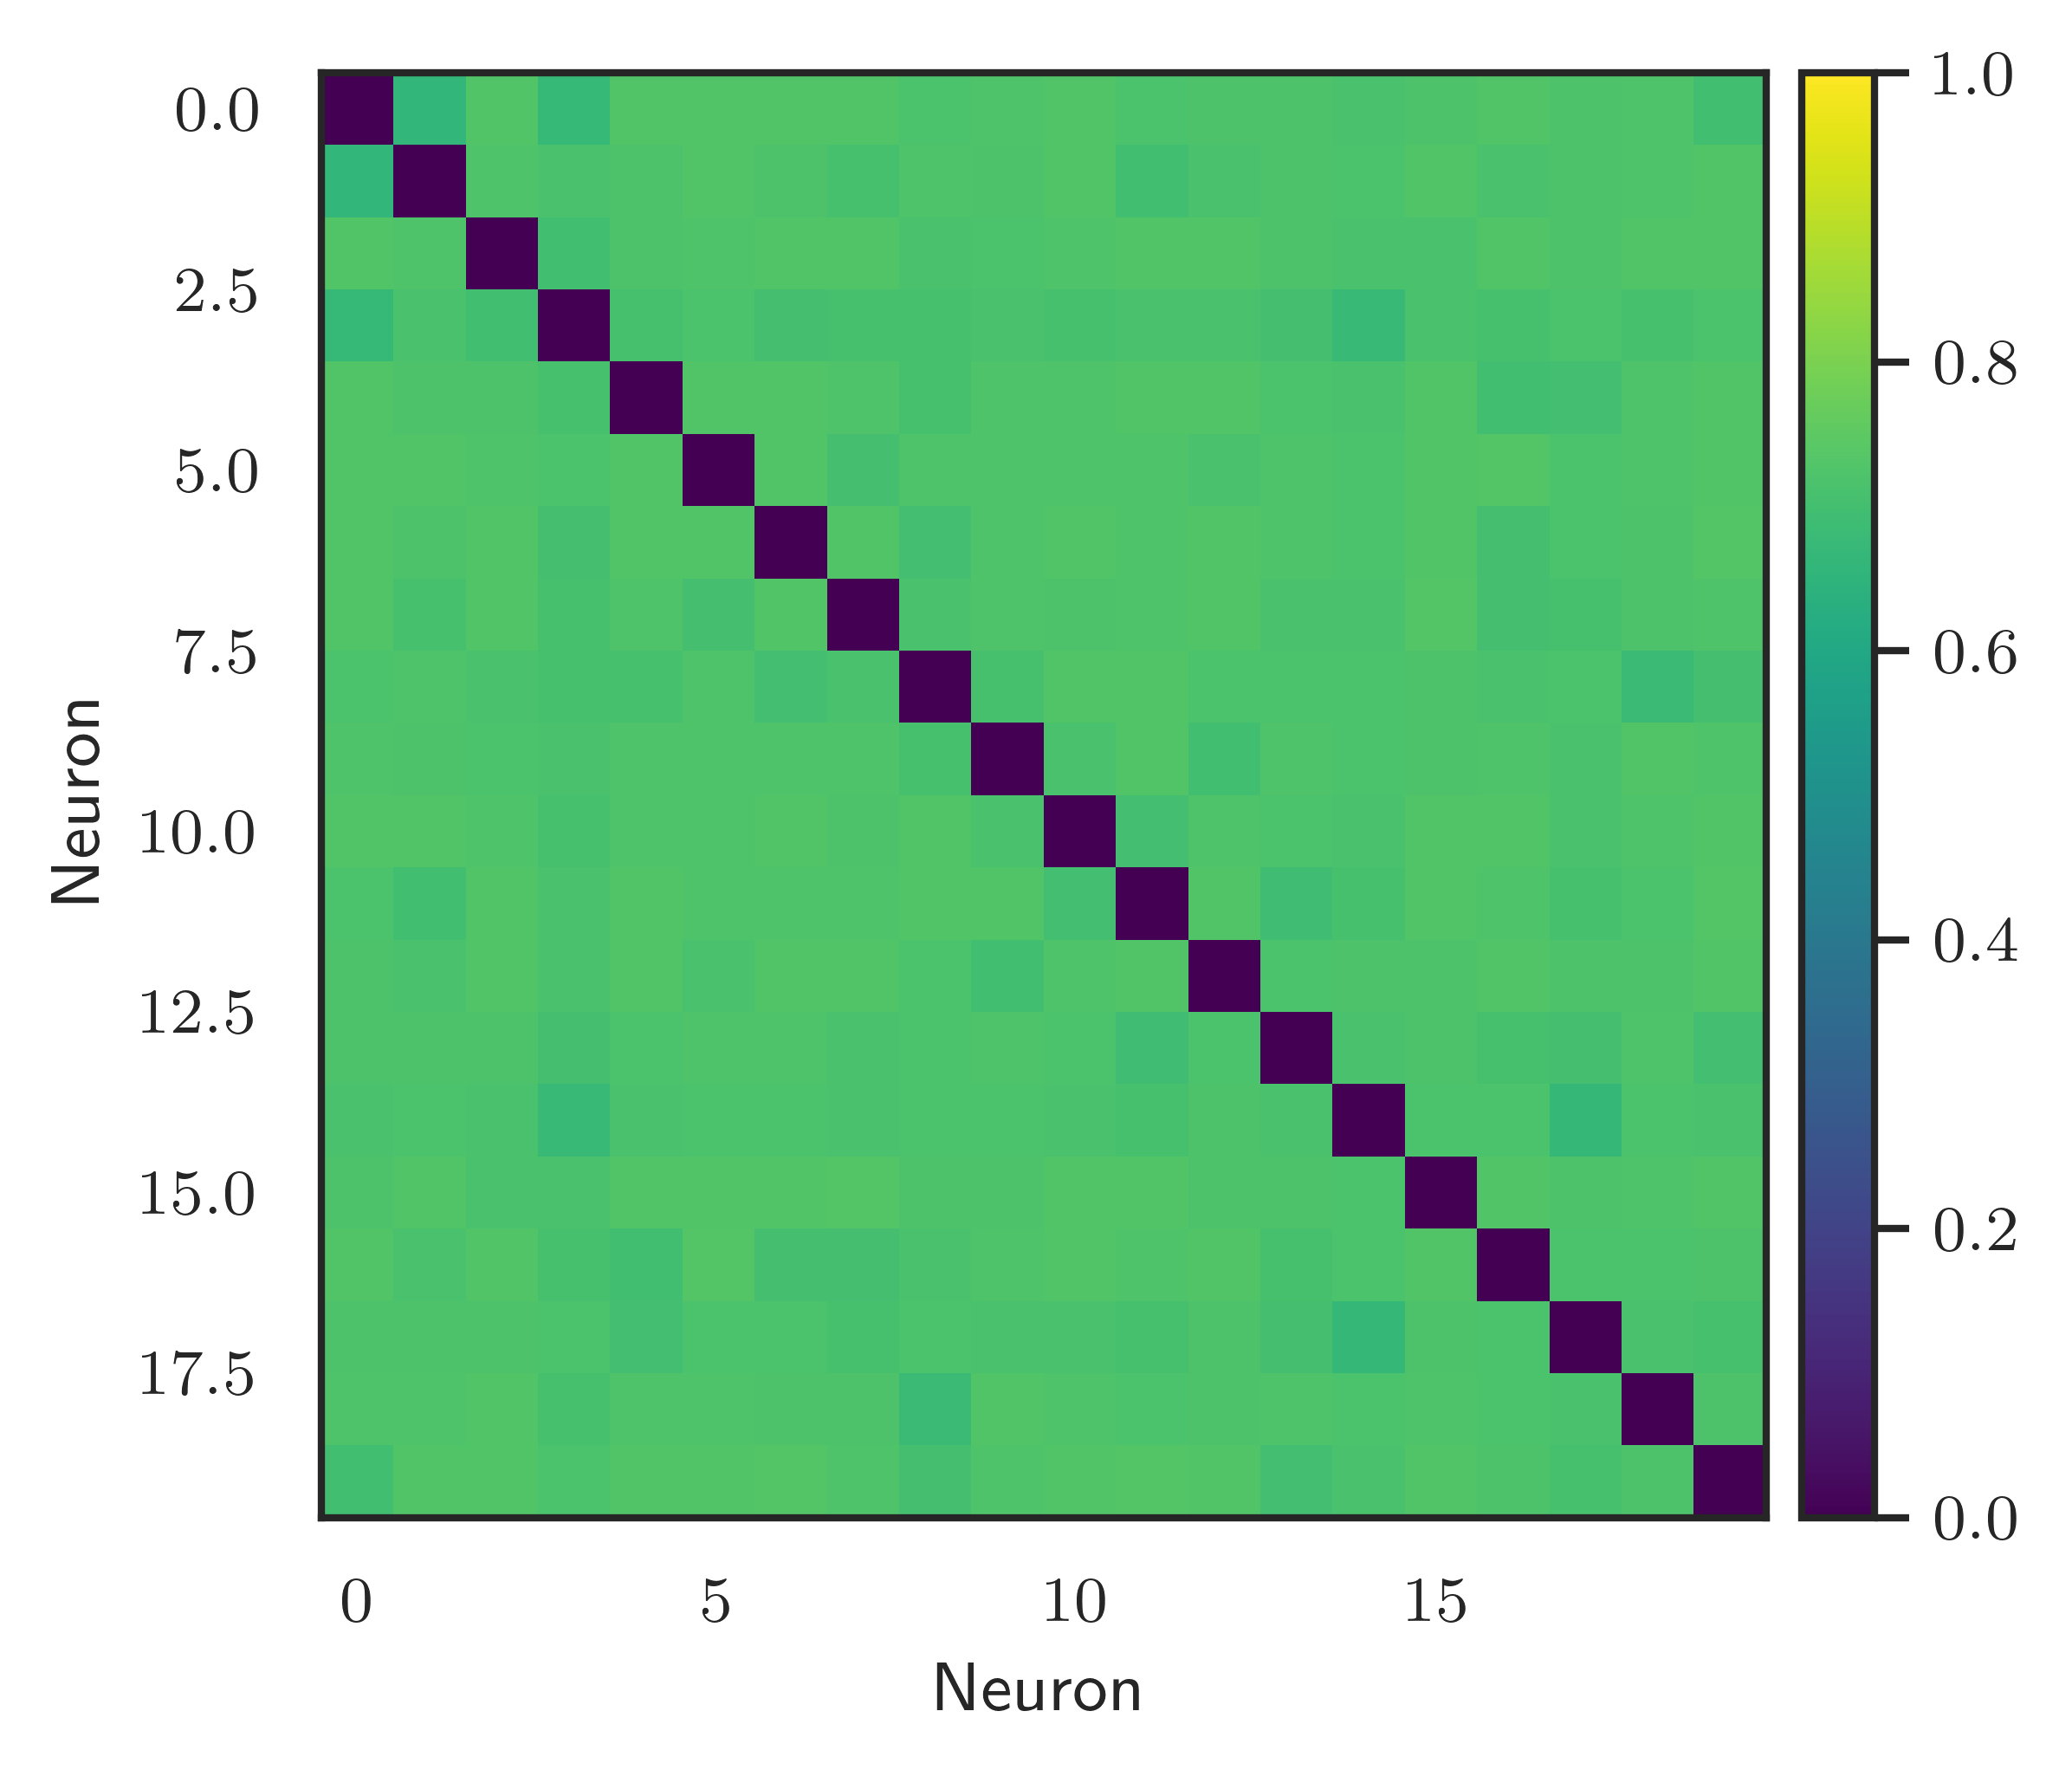

In [45]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize=fs, tight_layout=True, dpi=300)

    plot_corrcoef(corr_pred_sr_std, colormap='viridis', correlation_range=(0., 1.), axes=ax)

    ax.set(xlabel='Neuron',
           ylabel='Neuron',
           )

    fig.savefig(fig_path('brunel_pred_corr_std_sr_sbi.pdf'), 
                format='pdf', 
                dpi=300, 
                bbox_inches='tight'
               )


## Notes

Able to accurately predict summary statistics ...

Indicates that $\eta$ is not dominant in determining the dynamics of the SR state. 

Supported by the findings of (uncertainpy paper), where a sensitivity analysis of the Brunel model parameters was carried out. In the SR state, (uncertainpy paper) found that the Brunel network is most sensitive to the synaptic delay $D$ (which is kept constant in these results). However, the network was also found to be more sensitive to $g$ than $\eta$ in the SR state. 

In the AI state, the network was found to be most sensitive to the relative strength of inhibitory synapses $g$. The $\eta$ parameter also plays a role in the AI state, but not as much as $g$. The synaptic delay $D$ plays no role. 